<a href="https://colab.research.google.com/github/yslama/COVID-19/blob/master/Preliminary_Data_Exploration_Latest_May_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import datetime
import re
from math import cos, asin, sqrt, pi
import datetime
from datetime import datetime, date

# plotting

import matplotlib.pyplot as plt
import math
import warnings
import seaborn as sns
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import shapely.geometry
from shapely.geometry import Point, Polygon
# import pysal as ps
# from pysal.contrib.viz import mapping as maps
# from cartopy.mpl.geoaxes import GeoAxesSubplot
import plotly.offline as py
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import cufflinks as cf
cf.set_config_file(offline=True, sharing=False, theme='ggplot');

%matplotlib inline
sns.set()

# modeling
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import shap
from scipy.optimize import minimize

#For mapping
import requests
from xml.etree import ElementTree
import folium

#parametric curve fitting
from scipy import optimize

warnings.filterwarnings('ignore')

## Read-In Data

In [ ]:
# read files
df_may = pd.read_csv('0508_states.csv') # updated data
df_april = pd.read_csv('4.18states.csv')

In [ ]:
#Read files
confirmed_data_og = pd.read_csv('time_series_covid19_confirmed_US.csv')
death_data_og = pd.read_csv('time_series_covid19_deaths_US.csv')
county_data_og = pd.read_csv('abridged_couties.csv')

In [ ]:
#Keep original files
confirmed_data = confirmed_data_og.copy()
death_data = death_data_og.copy()
county_data = county_data_og.copy()

## Data Cleaning & Exploratory Data Analysis

## Rates Dataset

In [ ]:
df_april.head()

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,Alabama,US,2020-04-18 22:32:47,32.3182,-86.9023,4712,153,NaN,4559.0,1.0,100.492717,42538.0,620.0,3.247029,84000001,USA,907.206961,13.157895
1,Alaska,US,2020-04-18 22:32:47,61.3707,-152.4044,314,9,147.0,305.0,2.0,52.530410,9655.0,39.0,2.866242,84000002,USA,1615.226458,12.420382
2,American Samoa,US,NaN,-14.2710,-170.1320,0,0,NaN,NaN,60.0,0.000000,3.0,NaN,NaN,16,ASM,5.391708,NaN
3,Arizona,US,2020-04-18 22:32:47,33.7298,-111.4312,4724,180,539.0,4544.0,4.0,64.901548,51045.0,566.0,3.810330,84000004,USA,701.291175,11.981372
4,Arkansas,US,2020-04-18 22:32:47,34.9697,-92.3731,1744,38,703.0,1706.0,5.0,67.361213,24141.0,291.0,2.178899,84000005,USA,932.435235,16.685780


In [ ]:
df_may.head()

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,Alabama,US,2020-05-09 02:32:39,32.3182,-86.9023,9385,383,NaN,9002.0,1,200.153682,120114.0,1207.0,4.080980,84000001,USA,2561.668554,12.860948
1,Alaska,US,2020-05-09 02:32:39,61.3707,-152.4044,377,10,305.0,62.0,2,63.069951,25473.0,NaN,2.652520,84000002,USA,4261.487681,NaN
2,American Samoa,US,2020-05-09 02:32:39,-14.2710,-170.1320,0,0,NaN,0.0,60,0.000000,83.0,NaN,NaN,16,ASM,149.170576,NaN
3,Arizona,US,2020-05-09 02:32:39,33.7298,-111.4312,10526,517,1747.0,8262.0,4,144.613398,119907.0,1482.0,4.911647,84000004,USA,1647.364501,14.079422
4,Arkansas,US,2020-05-09 02:32:39,34.9697,-92.3731,3747,88,2159.0,1500.0,5,144.726185,63994.0,466.0,2.348546,84000005,USA,2471.739383,12.436616


In [ ]:
df_may = df_may[(df_may.Province_State != 'Diamond Princess') & 
                        (df_may.Province_State != 'Grand Princess') & 
                        (df_may.Province_State != 'Alaska') & 
                        (df_may.Province_State != 'Hawaii') &
                       (df_may.Province_State != 'American Samoa') &
                       (df_may.Province_State != 'Guam') &
                       (df_may.Province_State != 'Northern Mariana Islands') &
                       (df_may.Province_State != 'Puerto Rico') &
                       (df_may.Province_State != 'Virgin Islands')]


df_april = df_april[(df_april.Province_State != 'Diamond Princess') & 
                        (df_april.Province_State != 'Grand Princess') & 
                        (df_april.Province_State != 'Alaska') & 
                        (df_april.Province_State != 'Hawaii') &
                       (df_april.Province_State != 'American Samoa') &
                       (df_april.Province_State != 'Guam') &
                       (df_april.Province_State != 'Northern Mariana Islands') &
                       (df_april.Province_State != 'Puerto Rico') &
                       (df_april.Province_State != 'Virgin Islands')]

In [ ]:
df_may.isnull().sum()

Province_State           0
Country_Region           0
Last_Update              0
Lat                      0
Long_                    0
Confirmed                0
Deaths                   0
Recovered               13
Active                   0
FIPS                     0
Incident_Rate            0
People_Tested            0
People_Hospitalized     17
Mortality_Rate           0
UID                      0
ISO3                     0
Testing_Rate             0
Hospitalization_Rate    17
dtype: int64

## Deaths Time Series Dataset

In [ ]:
death_data.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,...,4,4,5,5,5,5,5,5,5,5
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.0979,145.6739,...,2,2,2,2,2,2,2,2,2,2
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.2208,-66.5901,...,33,39,42,44,45,45,51,56,58,60
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.3358,-64.8963,...,1,1,1,1,1,1,1,1,2,3


In [ ]:
death_data.columns

Index(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_', 'Combined_Key', 'Population',
       '1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20', '2/1/20', '2/2/20',
       '2/3/20', '2/4/20', '2/5/20', '2/6/20', '2/7/20', '2/8/20', '2/9/20',
       '2/10/20', '2/11/20', '2/12/20', '2/13/20', '2/14/20', '2/15/20',
       '2/16/20', '2/17/20', '2/18/20', '2/19/20', '2/20/20', '2/21/20',
       '2/22/20', '2/23/20', '2/24/20', '2/25/20', '2/26/20', '2/27/20',
       '2/28/20', '2/29/20', '3/1/20', '3/2/20', '3/3/20', '3/4/20', '3/5/20',
       '3/6/20', '3/7/20', '3/8/20', '3/9/20', '3/10/20', '3/11/20', '3/12/20',
       '3/13/20', '3/14/20', '3/15/20', '3/16/20', '3/17/20', '3/18/20',
       '3/19/20', '3/20/20', '3/21/20', '3/22/20', '3/23/20', '3/24/20',
       '3/25/20', '3/26/20', '3/27/20', '3/28/20', '3/29/20', '3/30/20',
       '3/31/20', '4/1/20', '4/2/20'

In [ ]:
# check country code identifiers
death_data.iso3.value_counts()

USA    3250
PRI       1
ASM       1
GUM       1
MNP       1
VIR       1
Name: iso3, dtype: int64

In [ ]:
# Very little data for countries not USA. drop these
# keep data from USA only, and drop iso2, iso3, code3, and Country_Region given that they are duplicates of 
# other columns
death_data = death_data[death_data.iso3 == 'USA'].drop(['iso2', 'iso3', 
                                                        'code3', 'Country_Region', 
                                                       'Combined_Key'], axis=1)

In [ ]:
death_data[death_data.Province_State == 'Texas']

,UID,FIPS,Admin2,Province_State,Lat,Long_,Population,1/22/20,1/23/20,1/24/20,...,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20
2528,84048001,48001.0,Anderson,Texas,31.815347,-95.653548,57735,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2529,84048003,48003.0,Andrews,Texas,32.304686,-102.637655,18705,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2530,84048005,48005.0,Angelina,Texas,31.254573,-94.609015,86715,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2531,84048007,48007.0,Aransas,Texas,28.105562,-96.999505,23510,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2532,84048009,48009.0,Archer,Texas,33.615700,-98.687546,8553,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2779,84048503,48503.0,Young,Texas,33.176597,-98.687909,18010,0,0,0,...,0,0,0,0,0,0,0,1,1,1
2780,84048505,48505.0,Zapata,Texas,27.001564,-99.169872,14179,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2781,84048507,48507.0,Zavala,Texas,28.866172,-99.760508,11840,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3192,84080048,80048.0,Out of TX,Texas,0.000000,0.000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


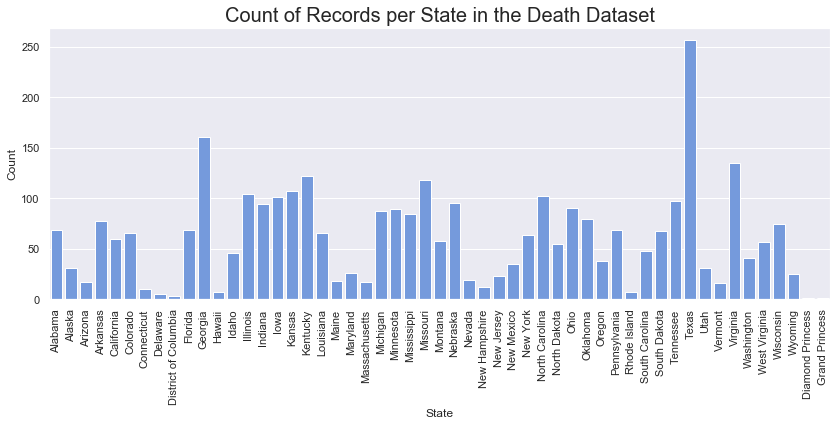

In [ ]:
# plot number of records per state
plt.figure(figsize=(14,5))
ax = sns.countplot(x='Province_State', data=death_data, color='cornflowerblue')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='center')
ax.set_xlabel('State')
ax.set_ylabel('Count')
ax.set_title('Count of Records per State in the Death Dataset', fontsize=20);

In [ ]:
# No data for american samoa, guam, northern mariana islands, puerto rico, and virgin islands. drop these
# let's focus on lower contiguous USA
# We also don't care about cruise ships, so drop the data from Diamond Princess and Grand Princess
death_data = death_data[(death_data.Province_State != 'Diamond Princess') & 
                        (death_data.Province_State != 'Grand Princess') & 
                        (death_data.Province_State != 'Alaska') & 
                        (death_data.Province_State != 'Hawaii') &
                       (death_data.Province_State != 'American Samoa') &
                       (death_data.Province_State != 'Guam') &
                       (death_data.Province_State != 'Northern Mariana Islands') &
                       (death_data.Province_State != 'Puerto Rico') &
                       (death_data.Province_State != 'Virgin Islands')]

In [ ]:
# rename Province_State column to state
death_data = death_data.rename(columns={'Province_State': 'state'})

In [ ]:
# rename Admin2 column to county_name
# also rename lat and lon columns for consistency
death_data = death_data.rename(columns={'Admin2': 'county_name',
                                               'Lat': 'lat', 'Long_': 'lon'})

In [ ]:
death_data[death_data.FIPS.isna()]

,UID,FIPS,county_name,state,lat,lon,Population,1/22/20,1/23/20,1/24/20,...,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20
3147,84070002,NaN,Dukes and Nantucket,Massachusetts,41.406747,-70.687635,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
3148,84070003,NaN,Kansas City,Missouri,39.099700,-94.578600,488943,0,0,0,...,7,8,8,8,8,12,12,12,13,13
3253,84070004,NaN,Michigan Department of Corrections (MDOC),Michigan,0.000000,0.000000,0,0,0,0,...,0,0,0,0,8,9,12,12,15,17
3254,84070005,NaN,Federal Correctional Institution (FCI),Michigan,0.000000,0.000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# county_id is null for special areas, for example prisons. drop these
death_data = death_data.drop(axis=0, index=[3253, 3254])

# also drop the data for Kansas City and the area between two counties
death_data = death_data.drop(axis=0, index=[3147, 3148])

In [ ]:
death_data.FIPS = death_data.FIPS.astype(int).astype(str)

In [ ]:
# ignore observations where county contains 'Out of'
# death_data = death_data[~death_data.county_name.str.contains("Out of")]
# death_data = death_data[~death_data.county_name.str.contains("Unassigned")]

In [ ]:
death_data.head()

,UID,FIPS,county_name,state,lat,lon,Population,1/22/20,1/23/20,1/24/20,...,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20
5,84001001,1001,Autauga,Alabama,32.539527,-86.644082,55869,0,0,0,...,1,1,1,1,1,1,1,1,2,2
6,84001003,1003,Baldwin,Alabama,30.727750,-87.722071,223234,0,0,0,...,1,1,1,1,1,2,2,2,2,2
7,84001005,1005,Barbour,Alabama,31.868263,-85.387129,24686,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,84001007,1007,Bibb,Alabama,32.996421,-87.125115,22394,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,84001009,1009,Blount,Alabama,33.982109,-86.567906,57826,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Confirmed Cases Dataset

In [ ]:
confirmed_data.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,...,128,130,133,133,133,133,135,135,136,136
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.0979,145.6739,...,11,11,11,11,11,11,13,13,13,14
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.2208,-66.5901,...,683,725,788,897,903,923,974,1043,1068,1118
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.3358,-64.8963,...,45,50,51,51,51,51,51,51,51,53


In [ ]:
confirmed_data.columns

Index(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_', 'Combined_Key', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20', '1/28/20', '1/29/20',
       '1/30/20', '1/31/20', '2/1/20', '2/2/20', '2/3/20', '2/4/20', '2/5/20',
       '2/6/20', '2/7/20', '2/8/20', '2/9/20', '2/10/20', '2/11/20', '2/12/20',
       '2/13/20', '2/14/20', '2/15/20', '2/16/20', '2/17/20', '2/18/20',
       '2/19/20', '2/20/20', '2/21/20', '2/22/20', '2/23/20', '2/24/20',
       '2/25/20', '2/26/20', '2/27/20', '2/28/20', '2/29/20', '3/1/20',
       '3/2/20', '3/3/20', '3/4/20', '3/5/20', '3/6/20', '3/7/20', '3/8/20',
       '3/9/20', '3/10/20', '3/11/20', '3/12/20', '3/13/20', '3/14/20',
       '3/15/20', '3/16/20', '3/17/20', '3/18/20', '3/19/20', '3/20/20',
       '3/21/20', '3/22/20', '3/23/20', '3/24/20', '3/25/20', '3/26/20',
       '3/27/20', '3/28/20', '3/29/20', '3/30/20', '3/31/20', '4/1/20',
       '4/2/20', '4/3/20', '4

In [ ]:
# check country code identifiers
confirmed_data.iso3.value_counts()

USA    3250
PRI       1
ASM       1
GUM       1
MNP       1
VIR       1
Name: iso3, dtype: int64

In [ ]:
# Very little data for countries not USA. drop these
# keep data from USA only, and drop iso2, iso3, code3, and Country_Region given that they are duplicates of 
# other columns
confirmed_data = confirmed_data[confirmed_data.iso3 == 'USA'].drop(['iso2', 'iso3', 
                                                                    'code3', 'Country_Region',
                                                                   'Combined_Key'], axis=1)

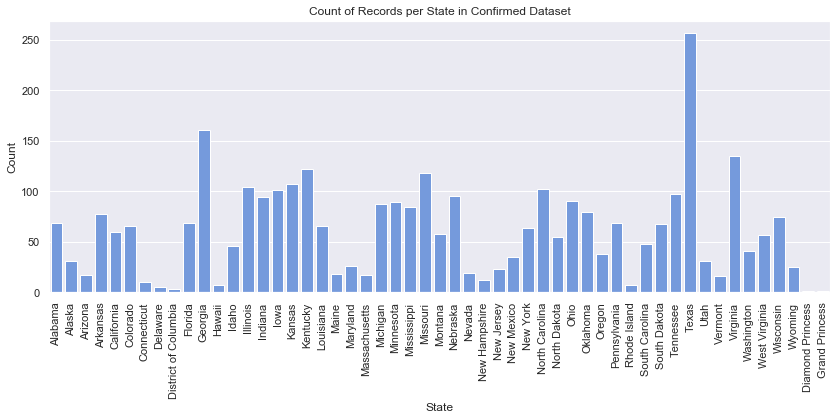

In [ ]:
plt.figure(figsize=(14,5))
ax = sns.countplot(x='Province_State', data=confirmed_data, color='cornflowerblue')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='center')
ax.set_xlabel('State')
ax.set_ylabel('Count')
ax.set_title('Count of Records per State in Confirmed Dataset');

In [ ]:
# Very little data for american samoa, guam, northern mariana islands, puerto rico, and virgin islands. drop these
# let's focus on lower contiguous USA
# We also don't care about cruise ships, so drop the data fro Diamond Princess and Grand Princess
confirmed_data = confirmed_data[(confirmed_data.Province_State != 'Diamond Princess') & 
                        (confirmed_data.Province_State != 'Grand Princess') & 
                        (confirmed_data.Province_State != 'Alaska') & 
                        (confirmed_data.Province_State != 'Hawaii') &
                       (confirmed_data.Province_State != 'American Samoa') &
                       (confirmed_data.Province_State != 'Guam') &
                       (confirmed_data.Province_State != 'Northern Mariana Islands') &
                       (confirmed_data.Province_State != 'Puerto Rico') &
                       (confirmed_data.Province_State != 'Virgin Islands')]

In [ ]:
# rename Province_State column to state
confirmed_data = confirmed_data.rename(columns={'Province_State': 'state'})

In [ ]:
# rename Admin2 column to county_name
# also rename lat and lon columns for consistency
confirmed_data = confirmed_data.rename(columns={'Admin2': 'county_name',
                                               'Lat': 'lat', 'Long_': 'lon'})

In [ ]:
# county_id is null for special areas, for example prisons. drop these
confirmed_data = confirmed_data.drop(axis=0, index=[3253, 3254])

# also drop the data for Kansas City and the area between two counties
confirmed_data = confirmed_data.drop(axis=0, index=[3147, 3148])

In [ ]:
confirmed_data.FIPS = confirmed_data.FIPS.astype(int).astype(str)

In [ ]:
# ignore observations where county contains 'Out of'
# confirmed_data = confirmed_data[~confirmed_data.county_name.str.contains("Out of")]

In [ ]:
confirmed_data.head()

,UID,FIPS,county_name,state,lat,lon,1/22/20,1/23/20,1/24/20,1/25/20,...,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20
5,84001001,1001,Autauga,Alabama,32.539527,-86.644082,0,0,0,0,...,15,17,19,19,19,23,24,26,26,25
6,84001003,1003,Baldwin,Alabama,30.727750,-87.722071,0,0,0,0,...,56,59,66,71,72,87,91,101,103,109
7,84001005,1005,Barbour,Alabama,31.868263,-85.387129,0,0,0,0,...,4,9,9,10,10,11,12,14,15,18
8,84001007,1007,Bibb,Alabama,32.996421,-87.125115,0,0,0,0,...,9,11,13,16,17,17,18,22,24,26
9,84001009,1009,Blount,Alabama,33.982109,-86.567906,0,0,0,0,...,11,12,12,13,14,16,17,18,20,20


### County Dataset

In [ ]:
county_data.head()

,countyFIPS,STATEFP,COUNTYFP,CountyName,StateName,State,lat,lon,POP_LATITUDE,POP_LONGITUDE,...,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,SVIPercentile,HPSAShortage,HPSAServedPop,HPSAUnderservedPop
0,01001,1.0,1.0,Autauga,AL,Alabama,32.540091,-86.645649,32.500389,-86.494165,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.4354,NaN,NaN,NaN
1,01003,1.0,3.0,Baldwin,AL,Alabama,30.738314,-87.726272,30.548923,-87.762381,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.2162,NaN,NaN,NaN
2,01005,1.0,5.0,Barbour,AL,Alabama,31.874030,-85.397327,31.844036,-85.310038,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.9959,6.08,5400.0,18241.0
3,01007,1.0,7.0,Bibb,AL,Alabama,32.999024,-87.125260,33.030921,-87.127659,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.6003,2.75,14980.0,6120.0
4,01009,1.0,9.0,Blount,AL,Alabama,33.990440,-86.562711,33.955243,-86.591491,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.4242,7.21,31850.0,25233.0


In [ ]:
county_data.isnull().sum().sort_values(ascending=True)

countyFIPS                              0
CountyName                              0
StateName                               0
PopMale5-92010                         19
PopFmle5-92010                         19
                                     ... 
3-YrMortalityAge15-24Years2015-17    2610
3-YrMortalityAge<1Year2015-17        2772
3-YrMortalityAge5-14Years2015-17     3149
mortality2015-17Estimated            3149
3-YrMortalityAge1-4Years2015-17      3179
Length: 87, dtype: int64

#### State Names

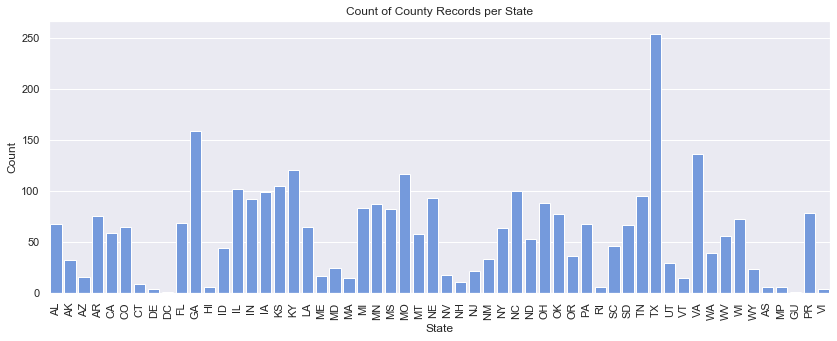

In [ ]:
plt.figure(figsize=(14,5))
ax = sns.countplot(x='StateName', data=county_data, color='cornflowerblue')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='center')
ax.set_xlabel('State')
ax.set_ylabel('Count')
ax.set_title('Count of County Records per State');

In [ ]:
# we want to look at lower contiguous USA only, so we delete the other regions
county_data = county_data[(county_data.StateName != 'AK')
                         & (county_data.StateName != 'HI')
                         & (county_data.StateName != 'GU')
                         & (county_data.StateName != 'GU')
                         & (county_data.StateName != 'AS')
                         & (county_data.StateName != 'PR')
                         & (county_data.StateName != 'MP')
                         & (county_data.StateName != 'PR')
                         & (county_data.StateName != 'VI')]

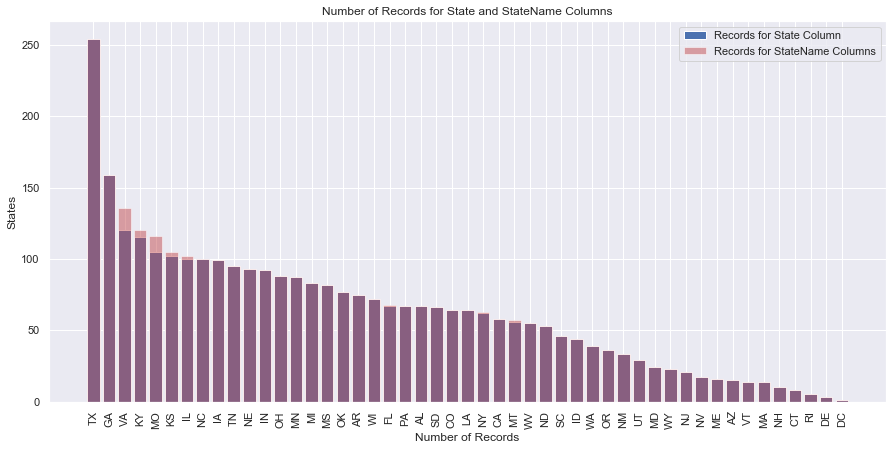

In [ ]:
# plot data for both states column to see if they are identical
missing_states = county_data.State.value_counts()
all_states = county_data.StateName.value_counts()

indices = np.arange(len(all_states))
width = 0.8

plt.figure(figsize=(15,7))
plt.bar(indices, missing_states, width=width, color='b', label='Records for State Column')
plt.bar(indices, all_states, width=width, color='r', alpha=0.5, label='Records for StateName Columns')

plt.xticks(indices, rotation=90, labels=all_states.index)
plt.legend()
plt.xlabel('Number of Records')
plt.ylabel('States')
plt.title('Number of Records for State and StateName Columns')

plt.show()

In [ ]:
# there are a lot of missing data points for state, but none for state. 
# replace missing data in state feature with equivalent in statename feature
county_data.loc[(county_data.StateName=="FL"),"State"]="Florida"
county_data.loc[(county_data.StateName=="MO"),"State"]="Missouri"
county_data.loc[(county_data.StateName=="MT"),"State"]="Montana"
county_data.loc[(county_data.StateName=="VA"),"State"]="Virginia"
county_data.loc[(county_data.StateName=="NY"),"State"]="New York"

In [ ]:
# drop rows with more than 15 missing values
county_data = county_data[county_data.isnull().sum(axis=1) < 15]

In [ ]:
# drop uninformative columns
county_data = county_data.drop(['STATEFP', 'COUNTYFP', 
                                'StateName', 'CensusRegionName','CensusDivisionName', 'CensusPopulation2010'], axis=1)

In [ ]:
# rename columns for consistency
county_data = county_data.rename(columns={'CountyName': 'county_name', 
                                          'State': 'state', 
                                          'POP_LATITUDE': 'lat_pop', 'POP_LONGITUDE': 'lon_pop', 
                                         'countyFIPS': 'FIPS'})

In [ ]:
# some id's in the FIPS column start with a 0, and do not match the FIPS data from the confirmed and death datasets.
# change the format
county_data.FIPS = county_data.FIPS.apply(lambda x: re.sub('^(0)','', x))

#### Demographics - Location

In [ ]:
# fill missing lat and lon manually :(
(county_data.loc[(county_data.county_name=="Alexandria City"),"lat"], 
 county_data.loc[(county_data.county_name=="Alexandria City"),"lon"]) = 39.1857, -78.1633

(county_data.loc[(county_data.county_name=="Bristol City"),"lat"], 
 county_data.loc[(county_data.county_name=="Bristol City"),"lon"]) = 36.5951, -82.1887

(county_data.loc[(county_data.county_name=="Buena Vista City"),"lat"], 
 county_data.loc[(county_data.county_name=="Buena Vista City"),"lon"]) = 37.7343, -79.3539

(county_data.loc[(county_data.county_name=="Charlottesville City"),"lat"], 
 county_data.loc[(county_data.county_name=="Charlottesville City"),"lon"]) = 38.0293, -78.4767

(county_data.loc[(county_data.county_name=="Chesapeake City"),"lat"], 
 county_data.loc[(county_data.county_name=="Chesapeake City"),"lon"]) = 36.7682, -76.2875

(county_data.loc[(county_data.county_name=="Colonial Heights Cit"),"lat"], 
 county_data.loc[(county_data.county_name=="Colonial Heights Cit"),"lon"]) = 37.2440, -77.4103

(county_data.loc[(county_data.county_name=="Covington City"),"lat"], 
 county_data.loc[(county_data.county_name=="Covington City"),"lon"]) = 39.0837, -84.5086

(county_data.loc[(county_data.county_name=="Danville City"),"lat"], 
 county_data.loc[(county_data.county_name=="Danville City"),"lon"]) = 36.5860, -79.3950

(county_data.loc[(county_data.county_name=="Emporia City"),"lat"], 
 county_data.loc[(county_data.county_name=="Emporia City"),"lon"]) = 36.6860, -77.5425

(county_data.loc[(county_data.county_name=="Fairfax City"),"lat"], 
 county_data.loc[(county_data.county_name=="Fairfax City"),"lon"]) = 38.8462, -77.3064

(county_data.loc[(county_data.county_name=="Falls Church City"),"lat"], 
 county_data.loc[(county_data.county_name=="Falls Church City"),"lon"]) = 38.8823, -77.1711

(county_data.loc[(county_data.county_name=="Franklin City"),"lat"], 
 county_data.loc[(county_data.county_name=="Franklin City"),"lon"]) = 36.6777, -76.9225

(county_data.loc[(county_data.county_name=="Fredericksburg City"),"lat"], 
 county_data.loc[(county_data.county_name=="Fredericksburg City"),"lon"]) = 38.3032, -77.4605

(county_data.loc[(county_data.county_name=="Galax City"),"lat"], 
 county_data.loc[(county_data.county_name=="Galax City"),"lon"]) = 36.6612, -80.9240

(county_data.loc[(county_data.county_name=="Harrisonburg City"),"lat"], 
 county_data.loc[(county_data.county_name=="Harrisonburg City"),"lon"]) = 38.4496, -78.8689

(county_data.loc[(county_data.county_name=="Hopewell City"),"lat"], 
 county_data.loc[(county_data.county_name=="Hopewell City"),"lon"]) = 37.3043, -77.2872

(county_data.loc[(county_data.county_name=="Lexington City"),"lat"], 
 county_data.loc[(county_data.county_name=="Lexington City"),"lon"]) = 37.7840, -79.4428

(county_data.loc[(county_data.county_name=="Lynchburg City"),"lat"], 
 county_data.loc[(county_data.county_name=="Lynchburg City"),"lon"]) = 37.4138, -79.1422

(county_data.loc[(county_data.county_name=="Manassas City"),"lat"], 
 county_data.loc[(county_data.county_name=="Manassas City"),"lon"]) = 38.7509, -77.4753

(county_data.loc[(county_data.county_name=="Martinsville City"),"lat"], 
 county_data.loc[(county_data.county_name=="Martinsville City"),"lon"]) = 36.6915, -79.8725

(county_data.loc[(county_data.county_name=="Norton City"),"lat"], 
 county_data.loc[(county_data.county_name=="Norton City"),"lon"]) = 36.9334, -82.6290

(county_data.loc[(county_data.county_name=="Petersburg City"),"lat"], 
 county_data.loc[(county_data.county_name=="Petersburg City"),"lon"]) = 37.2279, -77.4019

(county_data.loc[(county_data.county_name=="Poquoson City"),"lat"], 
 county_data.loc[(county_data.county_name=="Poquoson City"),"lon"]) = 37.1224, -76.3458

(county_data.loc[(county_data.county_name=="Portsmouth City"),"lat"], 
 county_data.loc[(county_data.county_name=="Portsmouth City"),"lon"]) = 36.8354, -76.2983

(county_data.loc[(county_data.county_name=="Radford City"),"lat"], 
 county_data.loc[(county_data.county_name=="Radford City"),"lon"]) = 37.1318, -80.5764

(county_data.loc[(county_data.county_name=="Richmond City"),"lat"], 
 county_data.loc[(county_data.county_name=="Richmond City"),"lon"]) = 37.5407, -77.4360

(county_data.loc[(county_data.county_name=="Roanoke City"),"lat"], 
 county_data.loc[(county_data.county_name=="Roanoke City"),"lon"]) = 37.2710, -79.9414

(county_data.loc[(county_data.county_name=="Salem City"),"lat"], 
 county_data.loc[(county_data.county_name=="Salem City"),"lon"]) = 37.2935, -80.0548

(county_data.loc[(county_data.county_name=="Staunton City"),"lat"], 
 county_data.loc[(county_data.county_name=="Staunton City"),"lon"]) = 38.1496, -79.0717

(county_data.loc[(county_data.county_name=="Waynesboro City"),"lat"], 
 county_data.loc[(county_data.county_name=="Waynesboro City"),"lon"]) = 38.0685, -78.8895

(county_data.loc[(county_data.county_name=="Winchester City"),"lat"], 
 county_data.loc[(county_data.county_name=="Winchester City"),"lon"]) = 39.1857, -78.1633

In [ ]:
# Create a to_center feature which calculates the distance from the county to the center of population in miles
def distance_to_center(lat1, lon1, lat2, lon2):
    p = pi/180
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return np.round(7918 * asin(sqrt(a)), 3) #2*R*asin...

# Identify distance from each county to the pop center
county_data['distance_to_center'] = (county_data
                                             .apply(lambda x: 
                                                    distance_to_center(
                                                        x['lat_pop'], x['lon_pop'], x['lat'], x['lon']), 
                                                    axis=1))

#### Population

In [ ]:
# only care about ratios. keep ratio of females to males
county_data = county_data.rename(columns = {'FracMale2017': 'frac_male'})

In [ ]:
# find proportion of people over 65
county_data = county_data.rename(columns = {'PopulationEstimate65+2017': 'prop_older_than_65'}) 
county_data['prop_older_than_65'] = (county_data['prop_older_than_65'] / 
                                     county_data[['PopTotalFemale2017','PopTotalMale2017']].sum(axis=1) * 100)

# county_data = county_data.drop(['PopTotalMale2017', 'PopTotalFemale2017'], axis=1)

In [ ]:
# drop population sizes for different age categories and gender
county_data = county_data.drop(['PopMale<52010', 'PopFmle<52010', 'PopMale5-92010', 
    'PopFmle5-92010', 'PopMale10-142010', 'PopFmle10-142010', 
    'PopMale15-192010', 'PopFmle15-192010', 'PopMale20-242010', 
    'PopFmle20-242010', 'PopMale25-292010', 'PopFmle25-292010', 
    'PopMale30-342010', 'PopFmle30-342010', 'PopMale35-442010', 
    'PopFmle35-442010', 'PopMale45-542010', 'PopFmle45-542010', 
    'PopMale55-592010', 'PopFmle55-592010', 'PopMale60-642010', 
    'PopFmle60-642010', 'PopMale65-742010', 'PopFmle65-742010', 
    'PopMale75-842010', 'PopFmle75-842010', 'PopMale>842010', 'PopFmle>842010'], axis=1)

#### Health Data

In [ ]:
# check percentage of missing data 
(county_data.isnull().sum()/county_data.shape[1]).sort_values(ascending=False).head(20)

3-YrMortalityAge1-4Years2015-17      54.111111
mortality2015-17Estimated            53.574074
3-YrMortalityAge5-14Years2015-17     53.574074
3-YrMortalityAge<1Year2015-17        46.722222
3-YrMortalityAge15-24Years2015-17    43.833333
3-YrMortalityAge25-34Years2015-17    37.777778
3-YrMortalityAge35-44Years2015-17    31.444444
3-YrDiabetes2015-17                  29.148148
HPSAUnderservedPop                   18.740741
HPSAShortage                         18.740741
HPSAServedPop                        18.740741
3-YrMortalityAge45-54Years2015-17    16.518519
stay at home                          7.111111
3-YrMortalityAge55-64Years2015-17     6.314815
3-YrMortalityAge65-74Years2015-17     3.444444
3-YrMortalityAge75-84Years2015-17     2.259259
3-YrMortalityAge85+Years2015-17       1.796296
>50 gatherings                        0.888889
>500 gatherings                       0.888889
entertainment/gym                     0.388889
dtype: float64

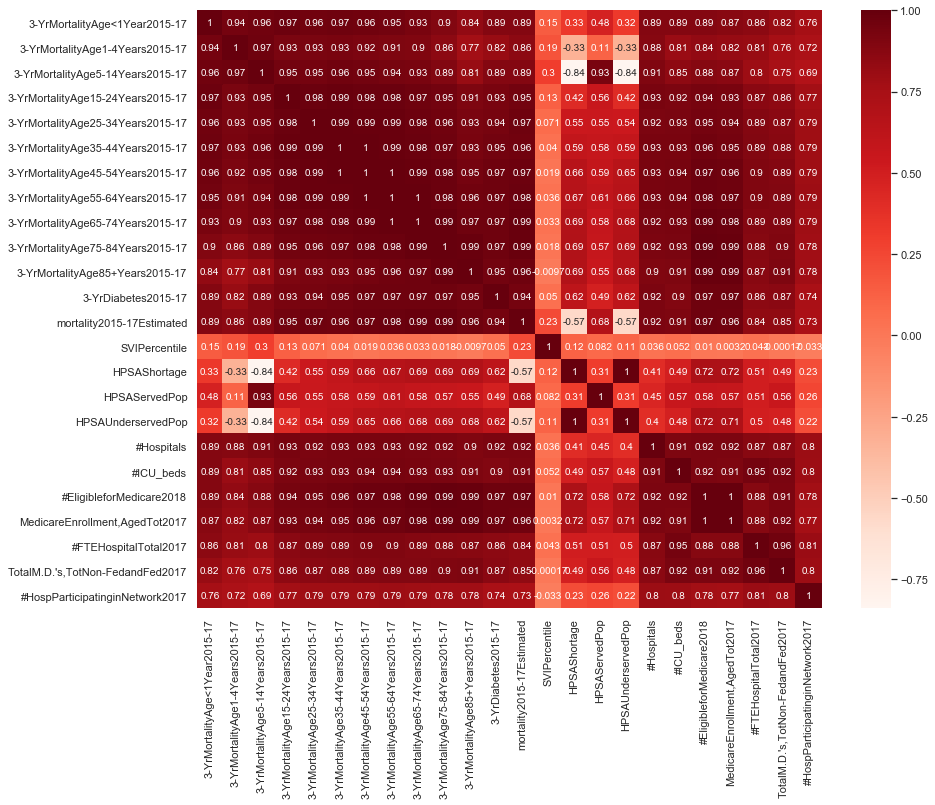

In [ ]:
# significant portion of the mortality data is missing
# check correlation between the mortality rates, the social vulnerability index, and number of health practitioners
plt.figure(figsize=(14,11))
cor = county_data[['3-YrMortalityAge<1Year2015-17',
       '3-YrMortalityAge1-4Years2015-17', '3-YrMortalityAge5-14Years2015-17',
       '3-YrMortalityAge15-24Years2015-17',
       '3-YrMortalityAge25-34Years2015-17',
       '3-YrMortalityAge35-44Years2015-17',
       '3-YrMortalityAge45-54Years2015-17',
       '3-YrMortalityAge55-64Years2015-17',
       '3-YrMortalityAge65-74Years2015-17',
       '3-YrMortalityAge75-84Years2015-17', 
       '3-YrMortalityAge85+Years2015-17', 
       '3-YrDiabetes2015-17',
       'mortality2015-17Estimated',
       'SVIPercentile', 'HPSAShortage', 'HPSAServedPop', 'HPSAUnderservedPop','#Hospitals', '#ICU_beds', 
       '#EligibleforMedicare2018', 'MedicareEnrollment,AgedTot2017',
       '#FTEHospitalTotal2017',
       "TotalM.D.'s,TotNon-FedandFed2017", '#HospParticipatinginNetwork2017'
                  ]].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds, annot_kws={"size": 10})
plt.show()

In [ ]:
# There is a high correlation between the majority of the mortality features, and other 
# illness-related and health preparedness features. let's drop the columns 
# related to mortality rate, HSPA related data, # of hospitals, and medicare, and 
# the number of doctors. Instead, we can keep ICU beds, 
# which might capture the information from these variables on its own
county_data = county_data.drop(['3-YrMortalityAge<1Year2015-17',
                           '3-YrMortalityAge1-4Years2015-17', 
                           '3-YrMortalityAge5-14Years2015-17',
                           '3-YrMortalityAge15-24Years2015-17',
                           '3-YrMortalityAge25-34Years2015-17',
                           '3-YrMortalityAge35-44Years2015-17',
                           '3-YrMortalityAge45-54Years2015-17',
                           '3-YrMortalityAge55-64Years2015-17',
                           '3-YrMortalityAge65-74Years2015-17',
                           '3-YrMortalityAge75-84Years2015-17', 
                           '3-YrMortalityAge85+Years2015-17', 
                           'mortality2015-17Estimated',
                           'SVIPercentile', '3-YrDiabetes2015-17',
                           'HPSAServedPop', 'HPSAUnderservedPop',
                           '#Hospitals', 'HPSAShortage',
                           '#EligibleforMedicare2018', 'MedicareEnrollment,AgedTot2017', 
                           '#FTEHospitalTotal2017',
                           "TotalM.D.'s,TotNon-FedandFed2017", '#HospParticipatinginNetwork2017'], axis=1)

In [ ]:
# assume:
# median age is constant from 2010-2018
# mortality and underlying disease rates are constant over the 10 years of interest
# population density is constant(increase in pop was max 1.4%)
county_data = county_data.rename(columns={'MedianAge2010': 'median_age', 
                                          'RespMortalityRate2014': 'resp_mortality_rate', 
                                          'HeartDiseaseMortality': 'heart_disease_mortality', 
                                          'StrokeMortality': 'stroke_mortality',
                                          'DiabetesPercentage': 'percent_diabetes',
                                          'Smokers_Percentage': 'percent_smoker',
                                          'PopulationDensityperSqMile2010': 'pop_density',
                                          'PopulationEstimate2018': 'population_estimate'})

#### COVID Response

In [ ]:
# rename columns for consistency
county_data = county_data.rename(columns={'Rural-UrbanContinuumCode2013': 'rural_urban_code',
                                         'stay at home': 'stay_at_home', 
                                          '>50 gatherings': 'gatherings_larger_than_50', 
                                          '>500 gatherings': 'gatherings_larger_than_500',
                                          'public schools': 'public_schools', 
                                          'restaurant dine-in': 'restaurant_dine_in', 
                                          'entertainment/gym': 'entertainment_gym',
                                          'federal guidelines': 'federal_guidelines', 
                                          'foreign travel ban': 'foreign_travel_ban'})

In [ ]:
# Replace missing values for when covid responses were taken with most recent date in dataset
last_date = '4/18/20'
datetime_last_date = datetime.strptime(last_date, '%m/%d/%y')
last_date_ord = datetime.toordinal(datetime_last_date)

In [ ]:
# the only state with null values for the gathering features are south and north dakota, both of 
# which never implemented laws opposing such gatherings
county_data.gatherings_larger_than_500 = county_data.gatherings_larger_than_500.fillna(last_date_ord)
county_data.gatherings_larger_than_50 = county_data.gatherings_larger_than_50.fillna(last_date_ord)

# similarly, some states never implemented a stay at home order. fill the missing data for those with 0
county_data.stay_at_home = county_data.stay_at_home.fillna(last_date_ord)
county_data.entertainment_gym = county_data.entertainment_gym.fillna(last_date_ord)

#### Days Since...

In [ ]:
# create a function to calculate the number of days since certain measures were implemented
def convert_days(column):
    county_data[column] = county_data[column].astype(int)
    county_data[column + '_closing_date'] = county_data[column].apply(lambda x: date.fromordinal(x))
    county_data[column + '_closing_date'] = pd.to_datetime(county_data[column + '_closing_date'])


    #Calculate how many days gyms have been closed as of 4/18/2020 
    ending_date = pd.to_datetime('20200418',format='%Y%m%d')
    county_data[column + '_duration'] = (ending_date - county_data[column + '_closing_date'])

    #format as integer
    county_data[column + '_duration'] = (county_data[column + '_duration']
                                                        .apply(lambda x: x/np.timedelta64(1,'D'))).astype(int)
    
    county_data.drop([column + '_closing_date', column], axis=1, inplace=True)
    return county_data

In [ ]:
col_days = ['stay_at_home', 'gatherings_larger_than_50', 'gatherings_larger_than_500', 'public_schools', 
'restaurant_dine_in', 'entertainment_gym']
for col in col_days:
    county_data = convert_days(col)

##### Check Statewide Features

In [ ]:
# Look at federal guidelines feature 
county_data.federal_guidelines.unique()

array([737500.])

In [ ]:
date.fromordinal(county_data['federal_guidelines'].unique().astype(int)[0])

datetime.date(2020, 3, 16)

In [ ]:
# Federal Guideliness were implemented for all counties on March 16. 
# Lets find the counties which had a case before the guidelines were ordered
before_federal_guidelines = (confirmed_data['3/16/20'] > 0).astype(int)

# create dataframe with info on which counties had cases before the travel ban
before_federal_guidelines = (pd.concat([confirmed_data.FIPS, before_federal_guidelines], axis=1)
                             .rename(columns={'3/16/20': 'cases_before_foreign_guidelines'}))

# combine the county dataset with the new data
county_data = county_data.merge(right = before_federal_guidelines, on='FIPS')

In [ ]:
# foreign travel ban was ordered statewide. Double check that it is a unique value
county_data['foreign_travel_ban'].unique()

array([737495.])

In [ ]:
# it is constant. Let's try creating a feature that indicates whether the travel 
# ban was put in place before or after each county's first confirmed case
date.fromordinal(county_data['foreign_travel_ban'].unique().astype(int)[0])

datetime.date(2020, 3, 11)

In [ ]:
# Foreign travel was banned on March 11. Lets find the counties which had a case before the order was put
before_foreign_ban = (confirmed_data['3/11/20'] > 0).astype(int)

# create dataframe with info on which counties had cases before the travel ban
before_foreign_ban = (pd.concat([confirmed_data.FIPS, before_foreign_ban], axis=1)
                      .rename(columns={'3/11/20': 'cases_before_travel_ban'}))

# combine the county dataset with the new data
county_data = county_data.merge(right = before_foreign_ban, on='FIPS')

#### Political Info

In [ ]:
###Classify democrat or republican based at county level###
county_data['political_party'] = np.where(county_data['dem_to_rep_ratio'] > 0.5,"Democrat","Republican")

In [ ]:
# Classify states as democratic or republican based on 2016 election results at the state level
county_data['political_party_state'] = np.where(
    (county_data['state'] == "Washington") | 
    (county_data['state'] == "Oregon") | 
    (county_data['state'] == "Nevada") |
    (county_data['state'] == "California") | 
    (county_data['state'] == "Colorado") | 
    (county_data['state'] == "New Mexico") |
    (county_data['state'] == "Minnesota") | 
    (county_data['state'] == "Illinois") |
    (county_data['state'] == "Vermont") | 
    (county_data['state'] == "New Hampshire") | 
    (county_data['state'] == "Maine") |
    (county_data['state'] == "Massachusetts") | 
    (county_data['state'] == "Rhode Island") | 
    (county_data['state'] == "Connecticut") |
    (county_data['state'] == "New Jersey") | 
    (county_data['state'] == "Delaware") | 
    (county_data['state'] == "Maryland") |
    (county_data['state'] == "District Of Columbia") | 
    (county_data['state'] == "Virginia") | 
    (county_data['state'] == "New York")
    , "Democrat","Republican")

# Death & Confirmed Count

In [ ]:
# create a new dataframe to count the total number of death and confirmed cases for each county
death_data_us = death_data.copy()
confirmed_data_us = confirmed_data.copy()

#Consider death and confirmed data from beginning day to end day, i.e Jan 22/2020 to April 18/2020 (Total 88 days)
# include FIPS identifier to merge with county dataframe
death_data_us = pd.concat([death_data_us.iloc[:,-88:], death_data_us.FIPS], axis=1)
confirmed_data_us = pd.concat([confirmed_data_us.iloc[:,-88:], confirmed_data_us.FIPS], axis=1)

In [ ]:
# find the total number of death and confrimed records for each state
total_death_count = death_data_us.iloc[:, :-1].sum(axis=1)
total_confirmed_count = confirmed_data_us.iloc[:, :-1].sum(axis=1)

# include the FIPS column to merge with county dataframe
total_death_count = pd.concat([total_death_count, death_data_us['FIPS']], axis=1).rename(columns={0: 'death_count'})
total_confirmed_count = (pd.concat([total_confirmed_count, confirmed_data_us['FIPS']], axis=1)
                         .rename(columns={0: 'confirmed_count'}))

In [ ]:
# add the confirmed count to the county dataframe
county_data = county_data.merge(right=total_confirmed_count, on='FIPS')
county_data = county_data.merge(right=total_death_count, on='FIPS')

In [ ]:
county_data.columns

Index(['FIPS', 'county_name', 'state', 'lat', 'lon', 'lat_pop', 'lon_pop',
       'rural_urban_code', 'population_estimate', 'PopTotalMale2017',
       'PopTotalFemale2017', 'frac_male', 'prop_older_than_65', 'pop_density',
       'median_age', 'percent_diabetes', 'heart_disease_mortality',
       'stroke_mortality', 'percent_smoker', 'resp_mortality_rate',
       '#ICU_beds', 'dem_to_rep_ratio', 'federal_guidelines',
       'foreign_travel_ban', 'distance_to_center', 'stay_at_home_duration',
       'gatherings_larger_than_50_duration',
       'gatherings_larger_than_500_duration', 'public_schools_duration',
       'restaurant_dine_in_duration', 'entertainment_gym_duration',
       'cases_before_foreign_guidelines', 'cases_before_travel_ban',
       'political_party', 'political_party_state', 'confirmed_count',
       'death_count'],
      dtype='object')

In [ ]:
# check basic statistics of death count
county_data['death_count'].describe()

count      2987.000000
mean        115.113827
std        2137.788720
min           0.000000
25%           0.000000
50%           0.000000
75%          19.000000
max      113671.000000
Name: death_count, dtype: float64

In [ ]:
# check basic statistics of confirmed count
county_data['confirmed_count'].describe()

count    2.987000e+03
mean     3.157188e+03
std      3.818524e+04
min      0.000000e+00
25%      3.000000e+01
50%      1.420000e+02
75%      6.175000e+02
max      1.887643e+06
Name: confirmed_count, dtype: float64

## Let's make some visualizations for death count

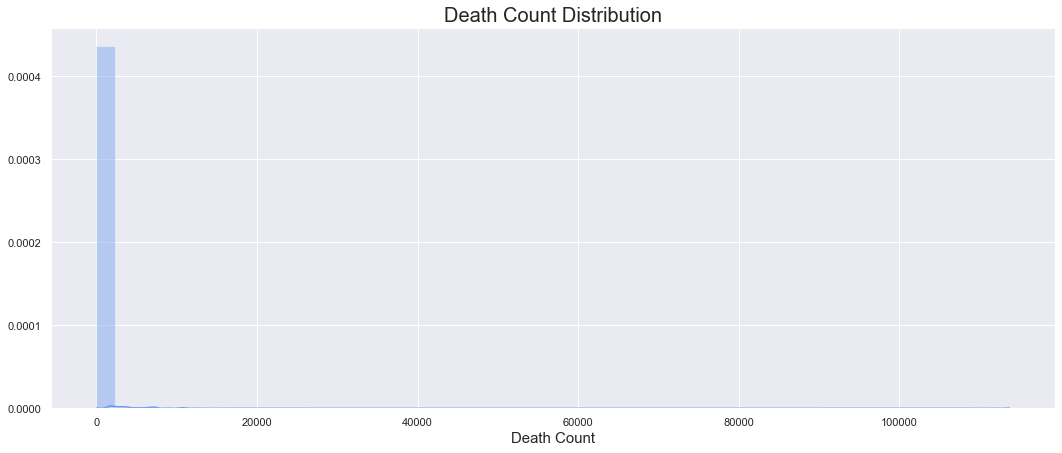

In [ ]:
# visualize death count
plt.figure(figsize=(18, 7))
ax = sns.distplot(county_data['death_count'], color='cornflowerblue')
ax.set_xlabel('Death Count', fontsize=15)
ax.set_title('Death Count Distribution', fontsize=20);  

In [ ]:
# The death count distribution is right skewed. 
# create a feature that is the log of the death count
county_data['log_death_count'] = np.log(county_data['death_count'])

In [ ]:
# drop all the counties with no confirmed cases - 
county_data_death = county_data[county_data.death_count > 0]

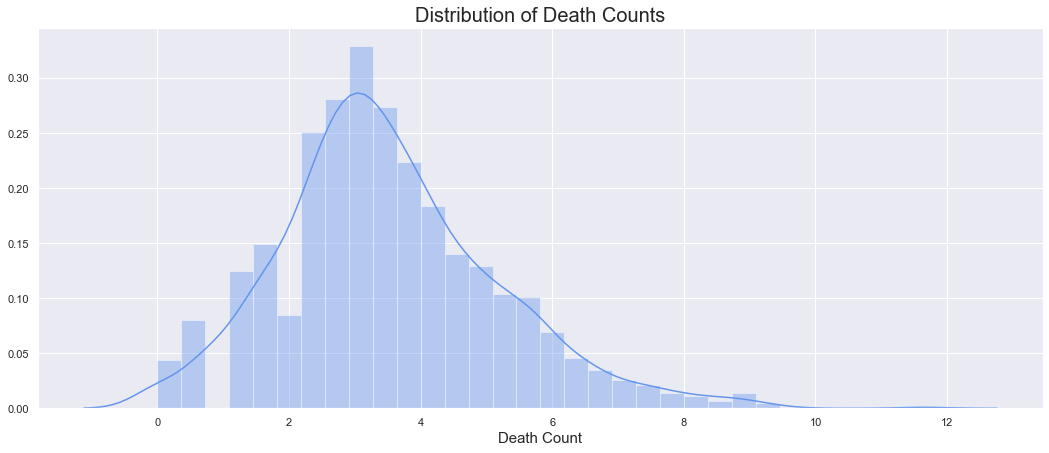

In [ ]:
# visualize death count
plt.figure(figsize=(18, 7))
ax = sns.distplot(county_data_death['log_death_count'], color='cornflowerblue')
# ax = sns.rugplot(county_data['death_count'], color='cornflowerblue')
ax.set_xlabel('Death Count', fontsize=15)
ax.set_title('Distribution of Death Counts', fontsize=20);  

In [ ]:
# select the columns we want to plot against the target feature
county_cols = ['population_estimate', 
               'frac_male',
               'prop_older_than_65', 
               'pop_density', 
               'median_age', 
               'percent_diabetes',
               'heart_disease_mortality', 
               'stroke_mortality', 
               'percent_smoker',
               'resp_mortality_rate', 
               '#ICU_beds', 
               'dem_to_rep_ratio', 
               'stay_at_home_duration',
               'gatherings_larger_than_50_duration', 
               'gatherings_larger_than_500_duration',
               'public_schools_duration', 
               'restaurant_dine_in_duration',
               'entertainment_gym_duration', 
               'cases_before_travel_ban',
               'cases_before_foreign_guidelines',
               'distance_to_center']

# generate titles for plotting purposes
county_titles = ['Population Estimate', 
                'Fraction Males',
                'Proportion of Population Above 65',
                'Population Density',
                'Median Age',
                 'Percent Diabetic',
                 'Heart Disease Mortality',
                 'Stroke Mortality',
                 'Percent Smoker',
                 'Respiratory Mortality Rate',
                 '# of ICU Beds',
                 'Democrat to Republican Ratio in County',
                 'Stay at Home Order Duration',
                 'Gatherings Larger than 50 Banned Order Duration',
                 'Gatherings Larger than 500 Banned Order Duration',
                 'Public Schools Closed Duration',
                 'Restaurants Dine-In Closed Duration',
                 'Entertaintment and Gym Closed Duration',
                 'Cases Before Foreign Travel Ban',
                 'Cases Before Federal Guidelines',
                 'Distance of County Center to Population Density Center'
                ]

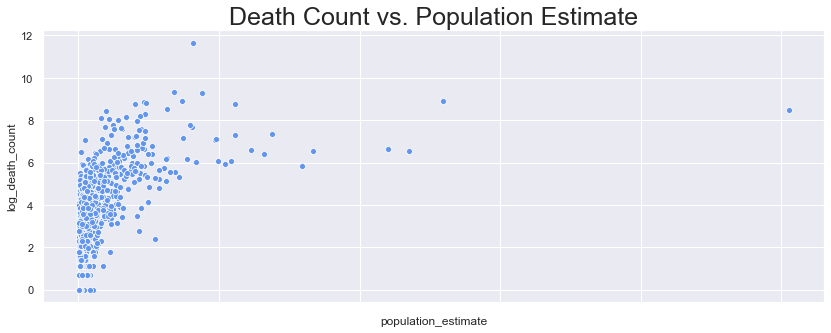

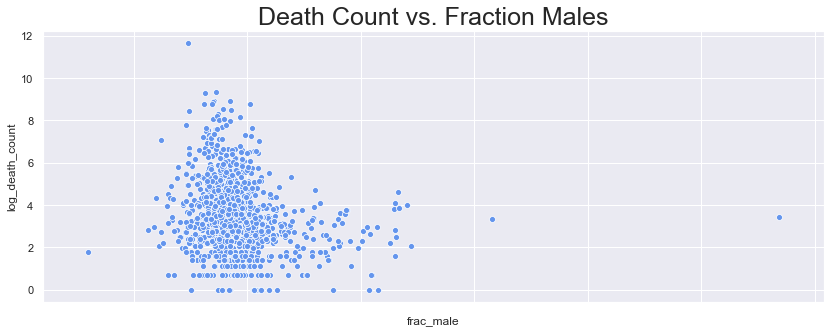

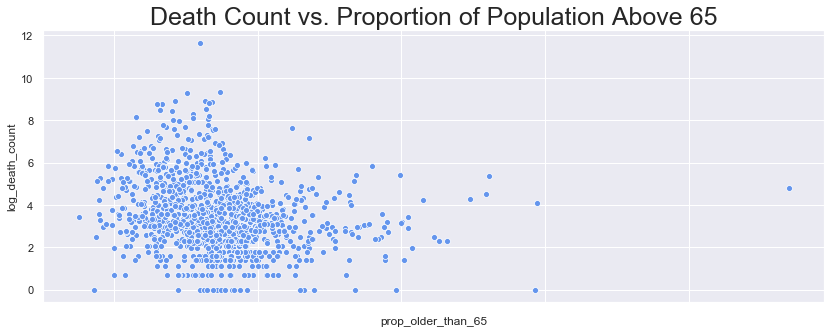

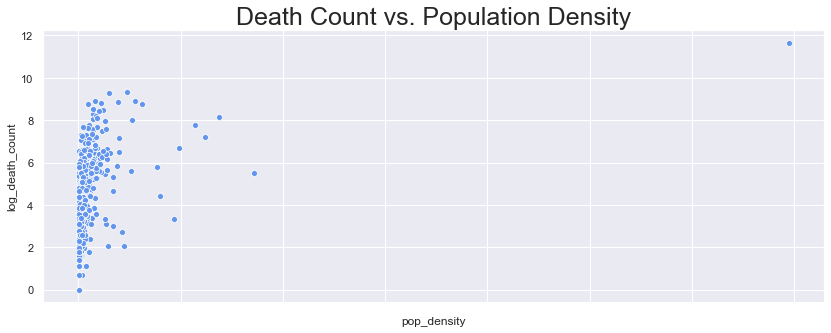

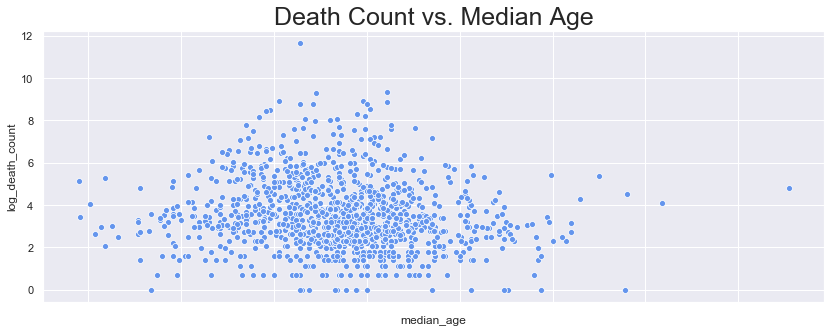

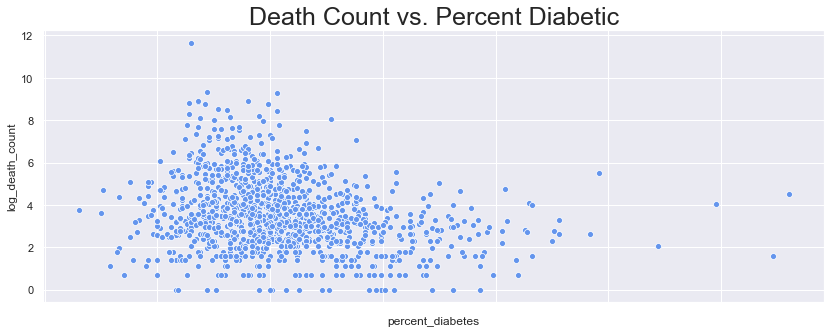

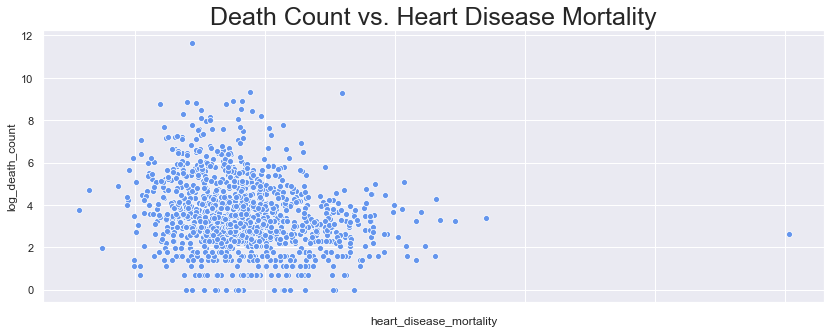

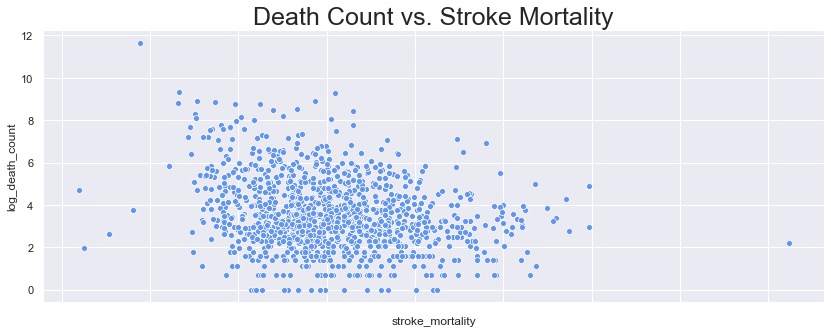

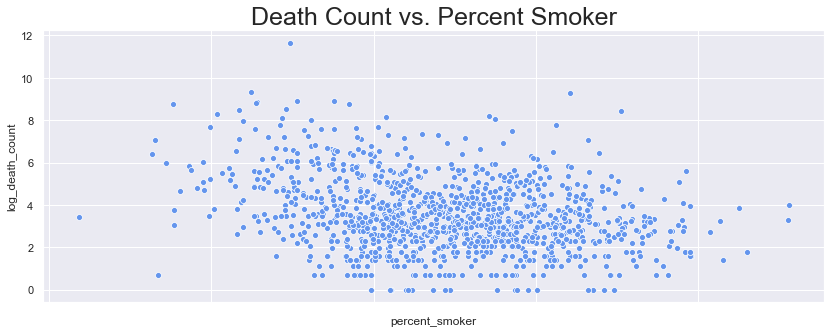

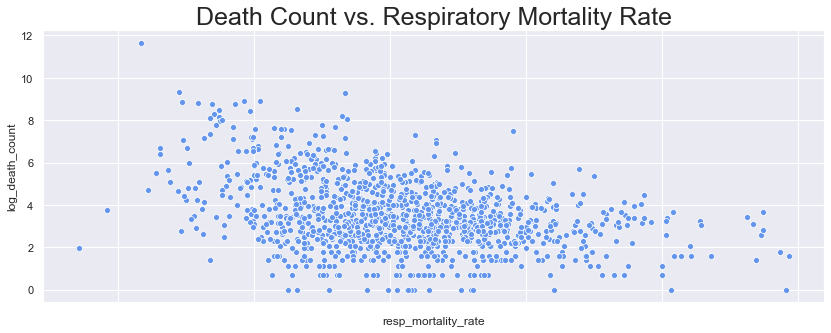

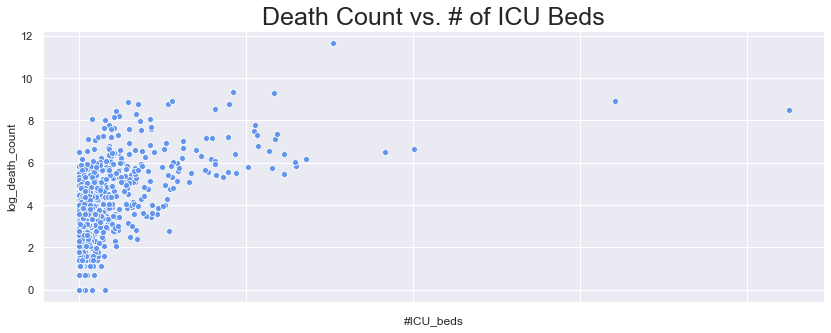

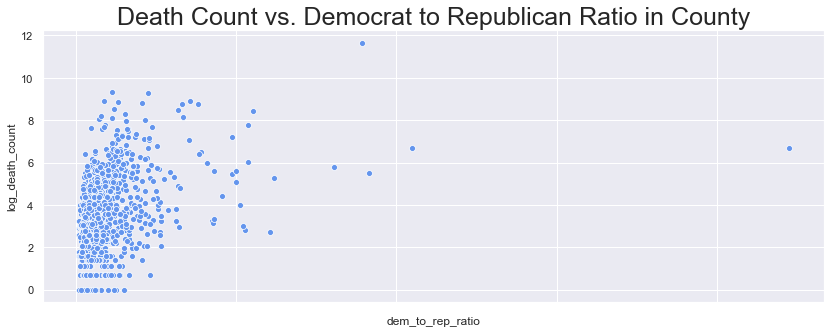

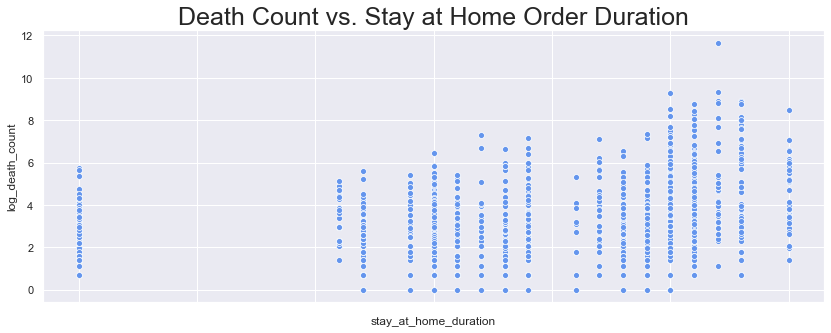

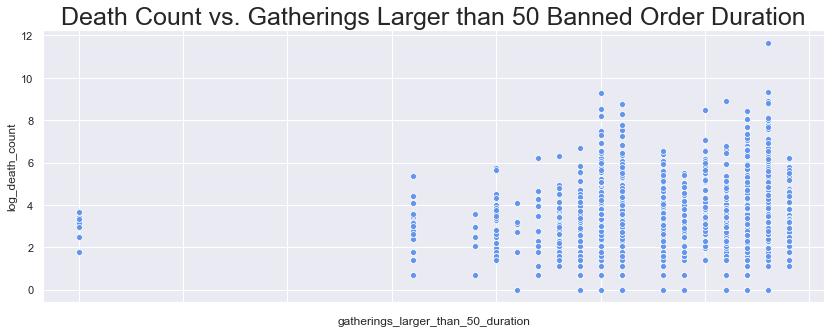

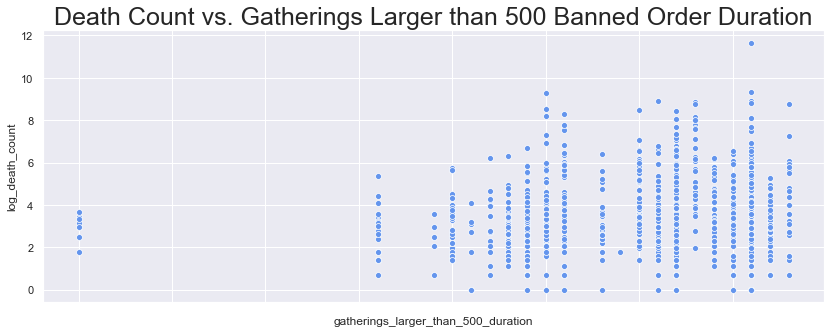

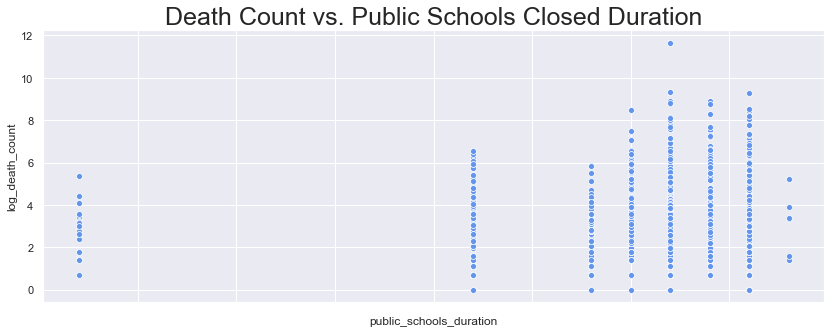

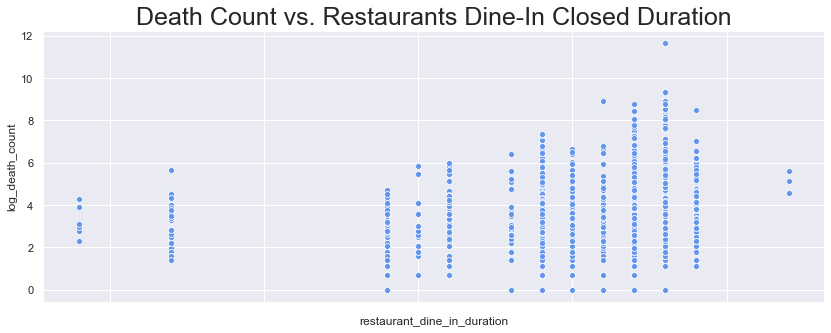

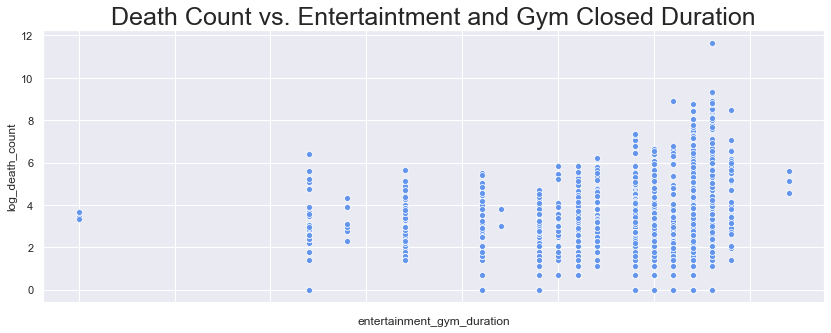

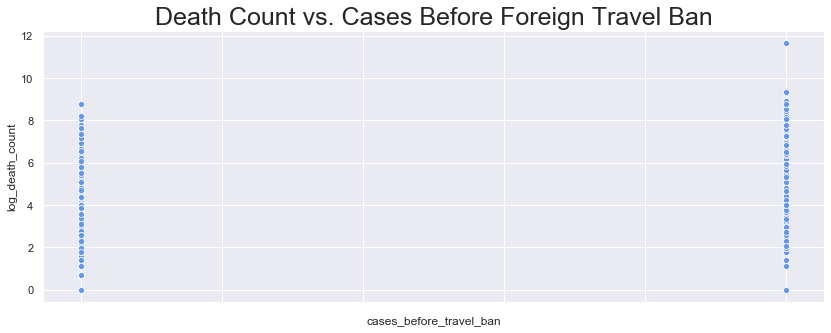

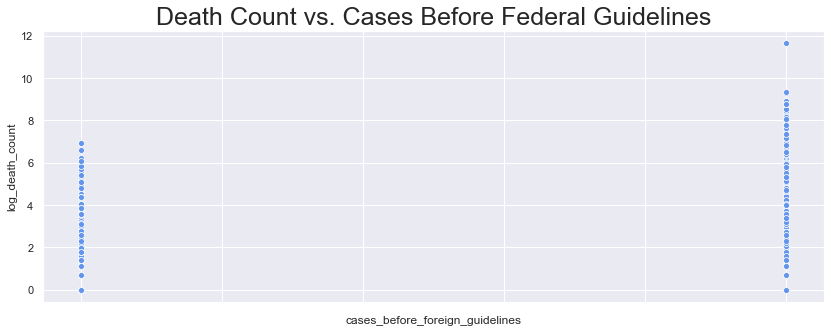

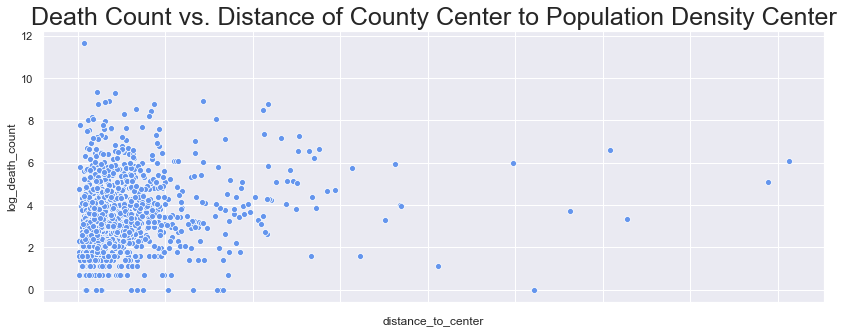

In [ ]:
for feature , title in zip(county_cols, county_titles):
    plt.figure(figsize=(14, 5))
    ax = sns.scatterplot(x=feature, y='log_death_count', data=county_data_death, color='cornflowerblue')
    labels = ax.get_xticklabels()
    ax.set_xticklabels(labels)
    ax.set_title('Death Count vs. '+title, fontsize=25);

In [ ]:
# check the relationship between rural-urban continuum code and death count

# first, limit the data because there are lots of outliers
county_data1=county_data[county_data["death_count"]!=0]

county_data2=county_data1[county_data1["death_count"]<1000]

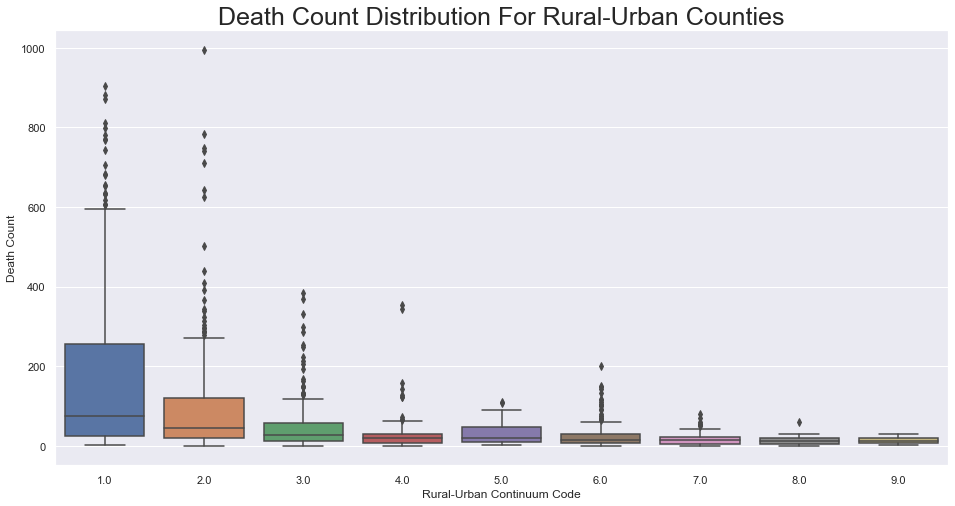

In [ ]:
plt.figure(figsize=(16,8))
ax = sns.boxplot(x='rural_urban_code', y='death_count', data=county_data2)
ax.set(xlabel='Rural-Urban Continuum Code', 
       ylabel='Death Count');
ax.set_title('Death Count Distribution For Rural-Urban Counties', fontsize=25);

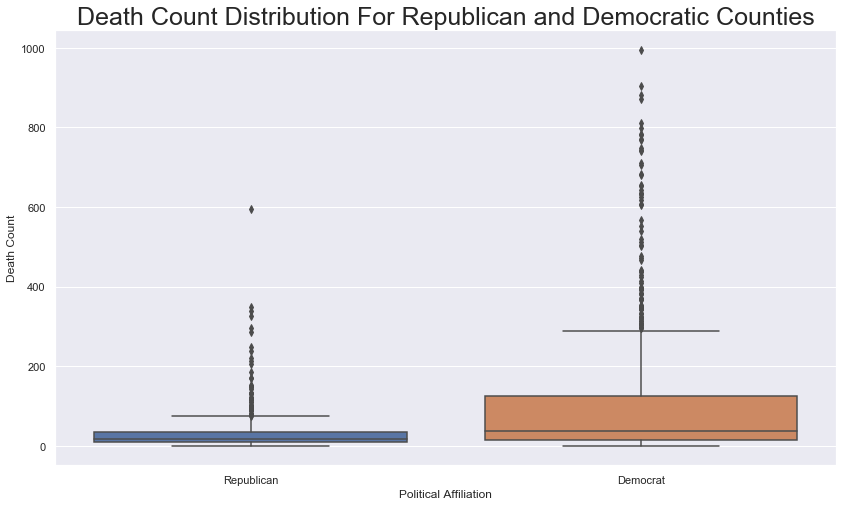

In [ ]:
# find death count distribution for republican/democrat counties 
plt.figure(figsize=(14,8))
ax = sns.boxplot(x='political_party', y='death_count', data=county_data2)
ax.set(xlabel='Political Affiliation', 
       ylabel='Death Count');
ax.set_title('Death Count Distribution For Republican and Democratic Counties', fontsize=25);

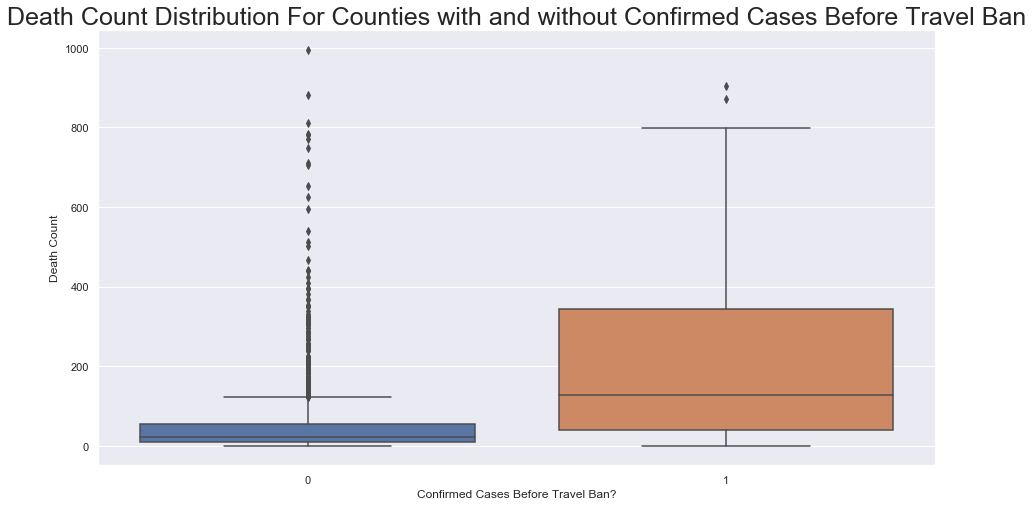

In [ ]:
# find death count distribution for counties which had cases before travel ban
plt.figure(figsize=(15,8))
ax = sns.boxplot(x='cases_before_travel_ban', y='death_count', data=county_data2)
ax.set(xlabel='Confirmed Cases Before Travel Ban?', 
       ylabel='Death Count');
ax.set_title('Death Count Distribution For Counties with and without Confirmed Cases Before Travel Ban', fontsize=25);

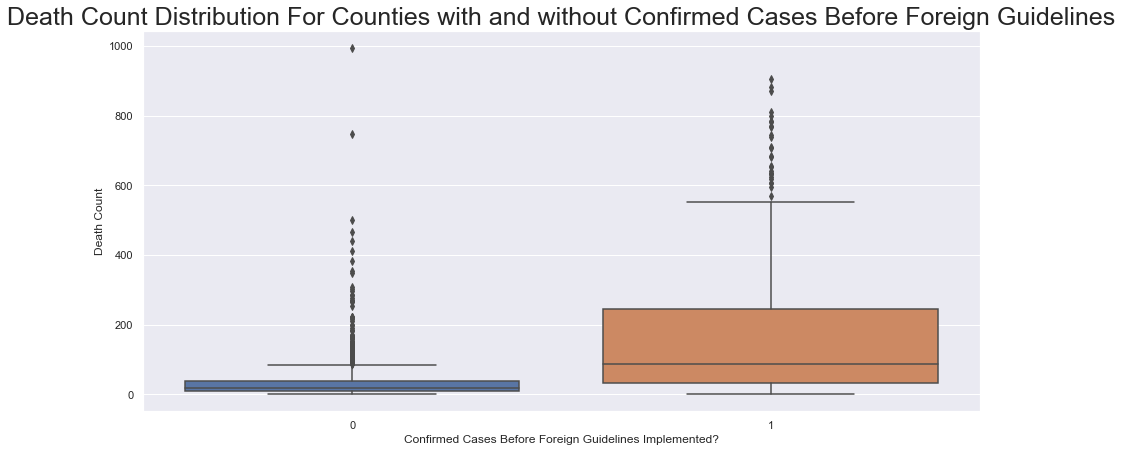

In [ ]:
# boxplot for countries that had a case before foreign guildelines and travel ban versus others. 
plt.figure(figsize=(15,7))
ax = sns.boxplot(x='cases_before_foreign_guidelines', y='death_count', data=county_data2)
ax.set(xlabel='Confirmed Cases Before Foreign Guidelines Implemented?', 
       ylabel='Death Count');
ax.set_title('Death Count Distribution For Counties with and without Confirmed Cases Before Foreign Guidelines', fontsize=25);

# Finally, before starting to model, let's make a plot of where the confirmed cases and deaths hotspots are in the country

In [ ]:
geom = gpd.GeoDataFrame(
    county_data_death, geometry=gpd.points_from_xy(county_data_death.lon, county_data_death.lat))

In [ ]:
def custom_div_cmap(numcolors=5, name='custom_div_cmap',
                    col1='yellowgreen',col2='gold',col3='orange',col4='red', col5='darkred'):
        """ Create a custom diverging colormap with seven colors """

        from matplotlib.colors import LinearSegmentedColormap 

        cmap = LinearSegmentedColormap.from_list(name=name, 
                                        colors =[col1, col2, col3, col4, col5],
                                            N=numcolors)
        return cmap

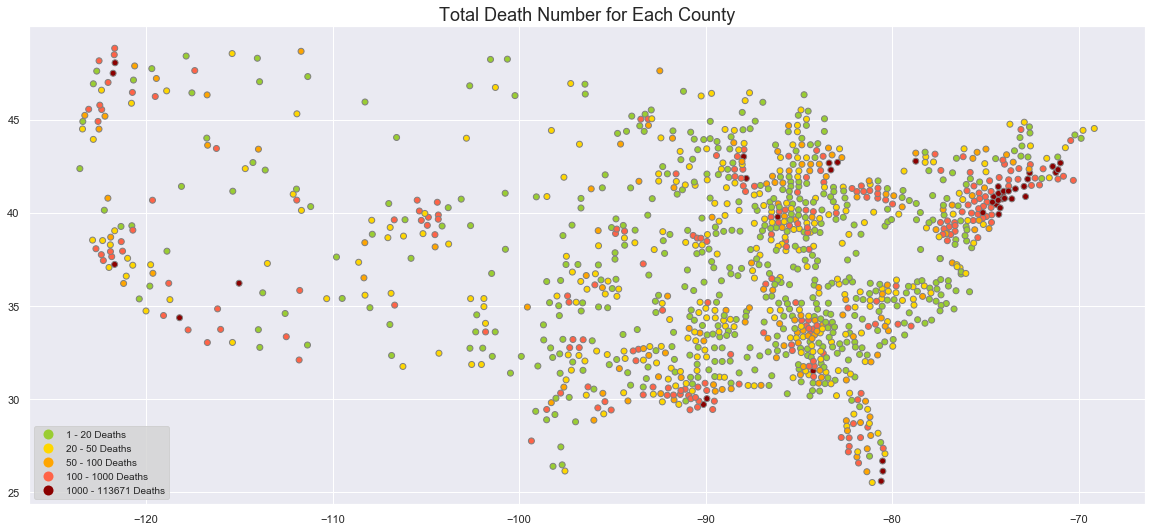

In [ ]:
#Plot showing where deaths are in the country
fig, ax = plt.subplots(1, 1)                  # initializing a figure
fig.set_size_inches(20,20)                      # setting the size

cmap=custom_div_cmap(5, col1='yellowgreen',col2='gold',col3='orange',col4='tomato', col5='darkred')  

bins=[20, 50, 100, 1000]                  # selecting classification bins
geom.plot(column='death_count', ax=ax, edgecolor='gray',
               cmap=cmap, legend=True, scheme='User_Defined', classification_kwds={'bins':bins}, 
               legend_kwds={'loc': 3, 'fontsize': 10, 'frameon':True})

# handling the legend appearance and labels
leg=ax.get_legend()
handles = leg.legendHandles
frame = leg.get_frame()
frame.set_facecolor('lightgray')
labels = ax.get_legend().get_texts()

for lbl in labels:                      # small loop to display legend labels as integers
    label_text = lbl.get_text()
    lower = label_text.split()[0]
    upper = label_text.split()[2]   
    new_text = '%.0f - %.0f' % (float(lower), float(upper))
    lbl.set_text(new_text+ " Deaths")

ax.axis('on')
ax.set_title('Total Death Number for Each County', fontsize=18)

plt.show()

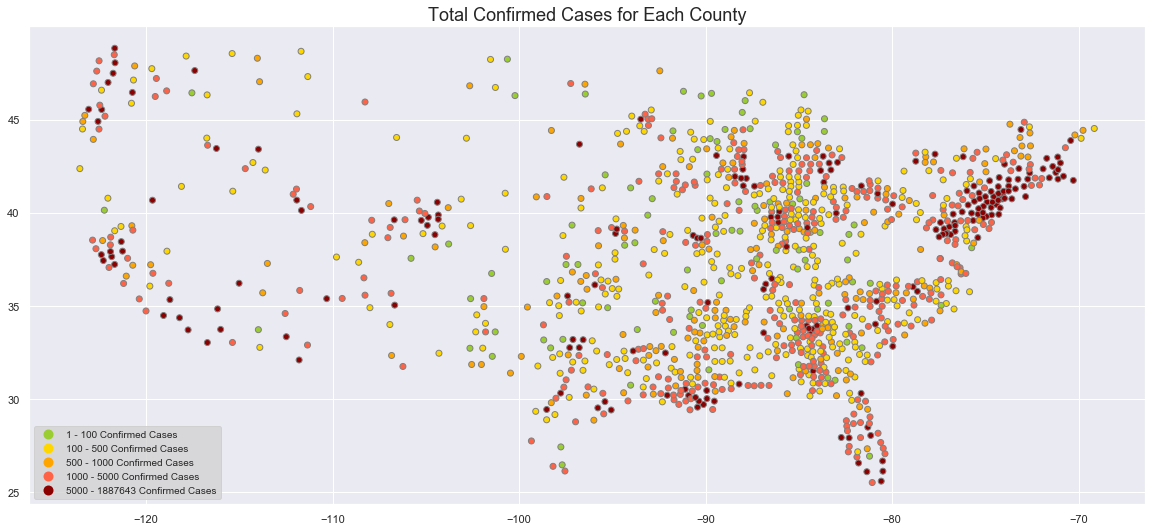

In [ ]:
#Plot showing where confirmed cases are in the country
fig, ax = plt.subplots(1, 1)                  # initializing a figure
fig.set_size_inches(20,20)                      # setting the size

cmap=custom_div_cmap(5, col1='yellowgreen',col2='gold',col3='orange',col4='tomato', col5='darkred')  

bins=[100, 500, 1000, 5000]                  # selecting classification bins
geom.plot(column='confirmed_count', ax=ax, edgecolor='gray',
               cmap=cmap, legend=True, scheme='User_Defined', classification_kwds={'bins':bins}, 
               legend_kwds={'loc': 3, 'fontsize': 10, 'frameon':True})

# handling the legend appearance and labels
leg=ax.get_legend()
handles = leg.legendHandles
frame = leg.get_frame()
frame.set_facecolor('lightgray')
labels = ax.get_legend().get_texts()

for lbl in labels:                      # small loop to display legend labels as integers
    label_text = lbl.get_text()
    lower = label_text.split()[0]
    upper = label_text.split()[2]   
    new_text = '%.0f - %.0f' % (float(lower), float(upper)) 
    lbl.set_text(new_text + " Confirmed Cases")

ax.axis('on')
ax.set_title('Total Confirmed Cases for Each County', fontsize=18)
plt.show()

# PCA

In [ ]:
# select features
county_pca = county_data.copy()

county_pca = county_data[['lat', 'lon', 'rural_urban_code', 'population_estimate', 
                        'frac_male', 'prop_older_than_65', 'pop_density',
                        'median_age', 'percent_diabetes', 'heart_disease_mortality',
                        'stroke_mortality', 'percent_smoker', 'resp_mortality_rate',
                        '#ICU_beds', 'dem_to_rep_ratio', 'federal_guidelines',
                        'foreign_travel_ban', 'distance_to_center', 'stay_at_home_duration',
                        'gatherings_larger_than_50_duration',
                        'gatherings_larger_than_500_duration', 'public_schools_duration',
                        'restaurant_dine_in_duration', 'entertainment_gym_duration',
                        'cases_before_foreign_guidelines', 'cases_before_travel_ban',
                        'political_party', 'confirmed_count']]


county_pca = pd.get_dummies(county_pca)

In [ ]:
from sklearn.preprocessing import StandardScaler

county_mean = county_pca.mean()
features = county_pca - county_mean

In [ ]:
# compute svd of our features
u, s, vt = np.linalg.svd(features, full_matrices = False)

In [ ]:
# select 2 pcs
county_2d = (features @ vt[:2, :].T).rename(columns={0: 'pc1', 1: 'pc2'})

In [ ]:
county_2d['pc1_jittered'] = county_2d['pc1'] + 1000*np.random.normal(loc = 0, scale = 100, size = county_2d.shape[0])
county_2d['pc2_jittered'] = county_2d['pc2'] + 1000*np.random.normal(loc = 0, scale = 100, size = county_2d.shape[0])

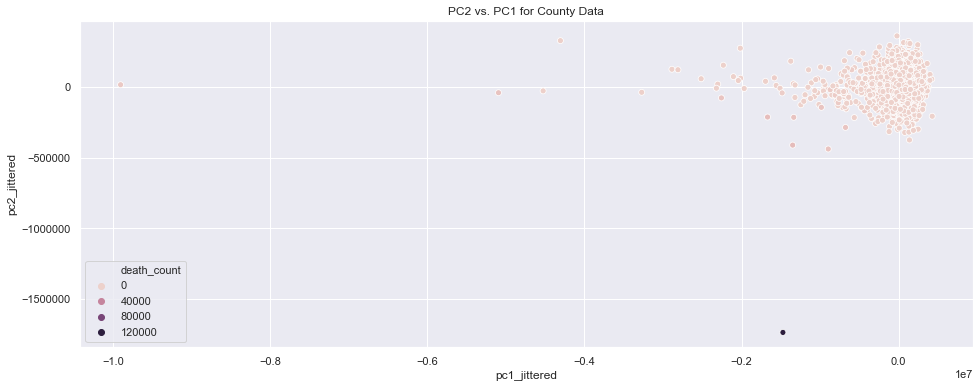

In [ ]:
plt.figure(figsize=(16, 6))
plt.title("PC2 vs. PC1 for County Data")
plt.xlabel("PC1")
plt.ylabel("PC2")
sns.scatterplot(county_2d['pc1_jittered'], county_2d['pc2_jittered'], hue=county_data.death_count)
plt.show()

PCA shows no clusters, and the data cannot be reduced to 2-D easily. 

# Modeling: Death Count

#### Scoring Functions

In [ ]:
def rmse_baseline(mean, y):
    return np.sqrt(np.mean((y - mean)**2))

def rmse_score(model, X, y):
    return np.sqrt(np.mean((y - model.predict(X))**2))


#### Data Manipulation

In [ ]:
# # convert ordinal data to type category and give it an order
# cat_dtype = pd.api.types.CategoricalDtype(categories=[1, 2, 3, 4, 5, 6, 7, 8], ordered=True)

# county_data.rural_urban_code = county_data.rural_urban_code.astype(cat_dtype)

## Baseline error for comparison

In [ ]:
# predict the mean
mean_deaths = county_data_death.log_death_count.mean()
mean_deaths

3.524506940598885

In [ ]:
#Use mean deaths as a constant predictor (baseline for comparison)
baseline_error = rmse_baseline(mean_deaths, county_data_death.log_death_count)
baseline_error

1.6557108643504157

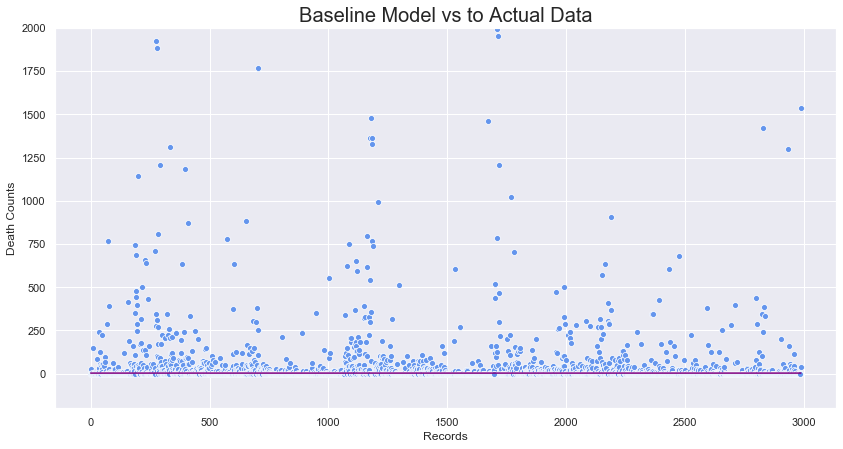

In [ ]:
plt.figure(figsize=(14, 7))
x = np.linspace(0, len(county_data), len(county_data))
sns.scatterplot(x=x, y=county_data['death_count'], color='cornflowerblue' )
sns.lineplot(x=x, y=mean_deaths, color='purple')
plt.ylim([-200, 2000])
plt.title('Baseline Model vs to Actual Data', fontsize=20)
plt.ylabel('Death Counts')
plt.xlabel('Records');

### OLS with SM to understand feature significance

In [ ]:
county_data_death_ols = county_data_death.copy()
county_data_death_ols.political_party = county_data_death_ols.political_party.astype('category')

In [ ]:
#Transform qualitative variable into dummy variable
county_data_death_ols = pd.get_dummies(county_data_death_ols, columns = ['political_party','political_party_state'], drop_first=True)

In [ ]:
all_features = ['lat_pop', 'lon_pop', 'frac_male',
                         'median_age', 'percent_diabetes','heart_disease_mortality','stroke_mortality','political_party_state_Republican',
                         'percent_smoker','resp_mortality_rate','#ICU_beds','distance_to_center',
                         'stay_at_home_duration','gatherings_larger_than_50_duration',
                         'gatherings_larger_than_500_duration','public_schools_duration',
                         'restaurant_dine_in_duration', 'entertainment_gym_duration',
                         'confirmed_count', 
                         'cases_before_foreign_guidelines', 
                         'cases_before_travel_ban', 'rural_urban_code', 
                         'political_party_Republican', 
                         'pop_density', 'population_estimate','prop_older_than_65']

In [ ]:
#Split into test and train set, random state ensures the results are reproducible and thus comparable across all the models
X_train, X_test, y_train, y_test = train_test_split(county_data_death_ols[all_features], 
                                                    county_data_death_ols['log_death_count'],
                                                    test_size=0.2, shuffle=True, random_state=42)

In [ ]:
# Let's use all 26 features in OLS model to identify feature significance
X_train = sm.add_constant(X_train)

model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        log_death_count   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     39.24
Date:                Wed, 13 May 2020   Prob (F-statistic):          3.73e-130
Time:                        16:11:30   Log-Likelihood:                -1478.8
No. Observations:                 955   AIC:                             3012.
Df Residuals:                     928   BIC:                             3143.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

### OLS with SKLearn

In [ ]:
county_data_death_lr = county_data_death.copy()
county_data_death_lr.political_party = county_data_death_lr.political_party.astype('category')
county_data_death_lr.political_party = county_data_death_lr.political_party_state.astype('category')

In [ ]:
county_data_death_lr = pd.get_dummies(county_data_death_lr, columns = ['political_party'], drop_first=True)
county_data_death_lr = pd.get_dummies(county_data_death_lr, columns = ['political_party_state'], drop_first=True)

In [ ]:
features = ['lat_pop', 'lon_pop', 'frac_male',
                         'median_age', 'percent_diabetes','heart_disease_mortality','stroke_mortality','political_party_state_Republican',
                         'percent_smoker','resp_mortality_rate','#ICU_beds','distance_to_center',
                         'stay_at_home_duration','gatherings_larger_than_50_duration',
                         'gatherings_larger_than_500_duration','public_schools_duration',
                         'restaurant_dine_in_duration', 'entertainment_gym_duration',
                         'confirmed_count', 
                         'cases_before_foreign_guidelines', 
                         'cases_before_travel_ban', 'rural_urban_code', 
                         'political_party_Republican', 
                         'pop_density', 'population_estimate','prop_older_than_65']

In [ ]:
#Split into test and train set, random state ensures the results are reproducible and thus comparable across all the models
X_train, X_test, y_train, y_test = train_test_split(county_data_death_lr[features],
                                                    county_data_death_lr['log_death_count'], 
                                                    test_size=0.2, shuffle=True, random_state=42)

In [ ]:
lr_model = Pipeline([
    # select features
    ("SelectColumns", ColumnTransformer([
            ("keep", "passthrough", features),
        ])),
    ("LinearModel", LinearRegression()) 
])  # pipeline close

# Fit the pipeline
lr_model.fit(X_train, y_train);

# Fit the pipeline
lr_model.fit(X_train, y_train);

In [ ]:
# Evaluate the RMSE of the validation error
validation_error = np.mean(cross_val_score(lr_model, X_train, y_train, scoring=rmse_score, cv=10))

print("Validation RMSE:", validation_error)


Validation RMSE: 1.2905539993908293


In [ ]:
train_error = rmse_score(lr_model, X_train, y_train)
test_error = rmse_score(lr_model, X_test, y_test)
print('train error:', train_error)
print('test error:', test_error)

train error: 1.1413133088452976
test error: 1.1984059982734345


In [ ]:
#Get coefficients for the model
lr_model['LinearModel'].coef_

array([-8.15751667e-03,  8.95309165e-03, -6.87129678e+00,  5.06296247e-02,
       -4.63083834e-02,  4.08346662e-03, -2.22224922e-03, -2.29191094e-02,
        2.32716555e-05, -1.07675069e-02,  2.29979844e-03,  4.28335292e-03,
        2.12998679e-02,  1.61672704e-02, -1.01164672e-02,  1.33258180e-02,
       -1.93207696e-02,  1.07566861e-02,  6.05613623e-06,  7.75241070e-01,
        1.82599396e-01, -1.42703235e-01, -2.29191094e-02, -7.50554694e-05,
        2.02857438e-07, -6.67952007e-02])

## The OLS model performs better than the baseline model, the test error is lower (1.20 compared to 1.66)

In [ ]:
# calculate residuals
y_fitted_lr = lr_model.predict(X_test)
residuals_lr = y_test - y_fitted_lr

# plot residuals to check for homoscedasticity
fig = go.Figure()
data_scatter = go.Scatter(x=y_fitted_lr, y=residuals_lr, 
                            mode="markers",
                            marker=dict(color='plum', size=8))
fig.add_trace(data_scatter)
fig.update_layout(height=400,
                 xaxis_title="Fitted Values",
                 yaxis_title="Residuals", 
                 title="Linear Regression Residual Plot")
fig

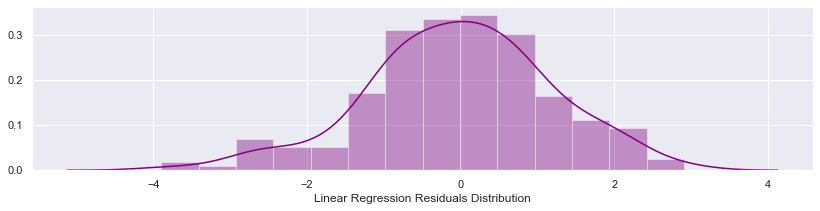

In [ ]:
#Check if the residuals are approximately normally distributed
plt.figure(figsize=(14,3))
sns.distplot(residuals_lr, color='purple');
plt.xlabel('Linear Regression Residuals Distribution');

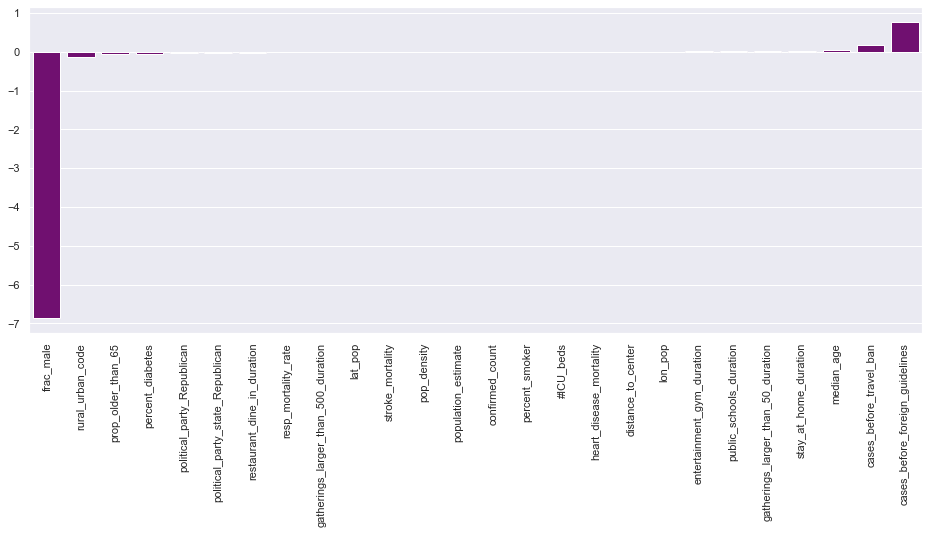

In [ ]:
# check feature importance
plt.figure(figsize=(16,6))
chart = sns.barplot(county_data_death_lr[features].columns[np.argsort(lr_model.named_steps['LinearModel'].coef_)], 
                    np.sort(lr_model.named_steps['LinearModel'].coef_), color='purple')
chart.set_xticklabels(chart.get_xticklabels(), rotation=90);

### Ridge Regression

In [ ]:
county_data_death_rr = county_data_death.copy()
county_data_death_rr.political_party = county_data_death_rr.political_party.astype('category')
county_data_death_rr = pd.get_dummies(county_data_death_rr, columns = ['political_party','political_party_state'], drop_first=True)

In [ ]:
#Use same features as OLS
ridge_features = ['lat_pop', 'lon_pop', 'frac_male',
                         'median_age', 'percent_diabetes','heart_disease_mortality','stroke_mortality','political_party_state_Republican',
                         'percent_smoker','resp_mortality_rate','#ICU_beds','distance_to_center',
                         'stay_at_home_duration','gatherings_larger_than_50_duration',
                         'gatherings_larger_than_500_duration','public_schools_duration',
                         'restaurant_dine_in_duration', 'entertainment_gym_duration',
                         'confirmed_count', 
                         'cases_before_foreign_guidelines', 
                         'cases_before_travel_ban', 'rural_urban_code', 
                         'political_party_Republican', 
                         'pop_density', 'population_estimate','prop_older_than_65']

In [ ]:
#Split into test and train set, random state ensures the results are reproducible and thus comparable across all the models
X_train, X_test, y_train, y_test = train_test_split(county_data_death_rr[ridge_features],
                                                    county_data_death_rr['log_death_count'],
                                                    test_size=0.2, shuffle=True, random_state=42)

In [ ]:
X_train_scaled = StandardScaler().fit_transform(X_train)
X_test_scaled= StandardScaler().fit_transform(X_test)

In [ ]:
alpha_arr = np.linspace(1, 2000, 120)
cv_errors = []

model_rr = Pipeline([
    ("transformer",StandardScaler()),
    ("LinearModel", Ridge(alpha=1.0))
])
for alpha in alpha_arr:
    model_rr.set_params(LinearModel__alpha=alpha)
        
    # compute the cross validation error
    cv_error = np.mean(cross_val_score(model_rr,X_train_scaled,y_train,scoring=rmse_score,cv=10))
    
    cv_errors.append(cv_error)
    
best_alpha_ridge = alpha_arr[np.argmin(cv_errors)]
print(f"The best alpha value is {best_alpha_ridge}")
print(f"Cross validation error for the best alpha value is {cv_errors[np.argmin(cv_errors)]}")

The best alpha value is 723.327731092437
Cross validation error for the best alpha value is 1.2783984608643204


In [ ]:
alpha = 723 # The regularization hyperparameter

# Initiate a model with the hyperparameter `alpha`
model_rr = Ridge(alpha = alpha)

# Fit the model
model_rr.fit(X_train, y_train);

# Evaluate the RMSE of the validation error
# Hint: Don't forget to take the mean!
validation_error = np.mean(cross_val_score(model_rr, X_train_scaled, y_train, scoring=rmse_score, cv=10))

print("Validation RMSE:", validation_error)

#fit the model
model_rr.fit(X_train_scaled, y_train);

Validation RMSE: 1.20022071996881


In [ ]:
#Train and test errors for RR model
train_error = rmse_score(model_rr, X_train_scaled, y_train)
test_error = rmse_score(model_rr, X_test_scaled, y_test)
print('train error:', train_error)
print('test error:', test_error)

train error: 1.17850858893202
test error: 1.1712776894905415


In [ ]:
#Get coefficients for the model
model_rr.coef_

array([-0.01569789,  0.08056131, -0.09579218,  0.00254708, -0.09259279,
        0.04296212, -0.03148945, -0.03052769, -0.03342928, -0.07789973,
        0.18771823,  0.02140473,  0.08878727,  0.0494735 , -0.00330255,
        0.04486424,  0.00541933,  0.02910198,  0.13314988,  0.21517545,
        0.104159  , -0.20463727, -0.08045855,  0.06983572,  0.17620631,
       -0.07947509])

## The Ridge Regression model performs better than the OLS model with a test error of 1.17 (compared to 1.20). Furthermore, the ridge model has less overfitting.

In [ ]:
# calculate residuals
y_fitted_rr = model_rr.predict(X_test_scaled)
residuals_rr = y_test - y_fitted_rr

# plot residuals
fig2 = go.Figure()
data_scatter = go.Scatter(x=y_fitted_rr, y=residuals_rr, 
                            mode="markers",
                            marker=dict(color='plum', size=8))
fig2.add_trace(data_scatter)
fig2.update_layout(height=400,
                 xaxis_title="Fitted Values",
                 yaxis_title="Residuals", 
                 title="Ridge Regression Residual Plot")
fig2

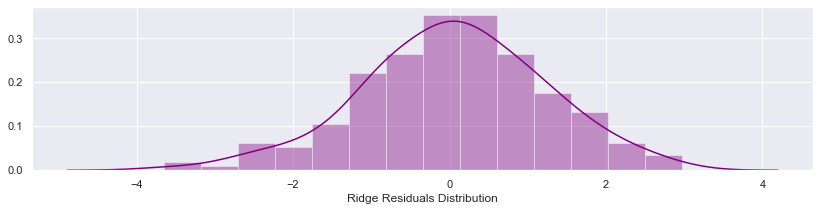

In [ ]:
#Check if the residuals are approximately normally distributed
plt.figure(figsize=(14,3))
sns.distplot(residuals_rr, color='purple');
plt.xlabel('Ridge Residuals Distribution');

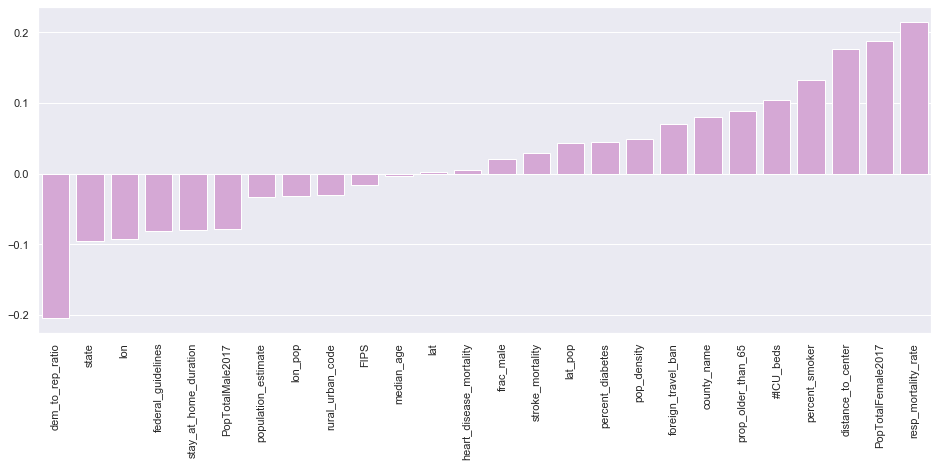

In [ ]:
# check feature importance
plt.figure(figsize=(16,6))
chart = sns.barplot(county_data_death_rr.columns[np.argsort(model_rr.coef_)], np.sort(model_rr.coef_), color='plum')
chart.set_xticklabels(chart.get_xticklabels(), rotation=90);

## Random Forest Regression

In [ ]:
county_data_death_rf = county_data_death.copy()
county_data_death_rf.political_party = county_data_death_rf.political_party.astype('category')
county_data_death_rf = pd.get_dummies(county_data_death_rf, columns = ['political_party','political_party_state'], drop_first=True)

In [ ]:
rf_features = ['lat_pop', 'lon_pop', 'frac_male',
                         'median_age', 'percent_diabetes','heart_disease_mortality','stroke_mortality','political_party_state_Republican',
                         'percent_smoker','resp_mortality_rate','#ICU_beds','distance_to_center',
                         'stay_at_home_duration','gatherings_larger_than_50_duration',
                         'gatherings_larger_than_500_duration','public_schools_duration',
                         'restaurant_dine_in_duration', 'entertainment_gym_duration',
                         'confirmed_count', 
                         'cases_before_foreign_guidelines', 
                         'cases_before_travel_ban', 'rural_urban_code', 
                         'political_party_Republican', 
                         'pop_density', 'population_estimate','prop_older_than_65']

In [ ]:
#Split into test and train set, random state ensures the results are reproducible and thus comparable across all the models
X_train, X_test, y_train, y_test = train_test_split(county_data_death_rf[rf_features], 
                                                    county_data_death_rf['log_death_count'], 
                                                    test_size=0.2, random_state=42, shuffle=True)

In [ ]:
#Randomized grid search for best parameters for RF
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['sqrt', 0.33]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 20, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [1, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4, 6]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   32.5s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [ ]:
#Get best parameters
rf_random.best_params_

{'n_estimators': 555,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 0.33,
 'max_depth': 10,
 'bootstrap': True}

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [5],
    'max_features': [0.33],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [3, 5, 6, 7],
    'n_estimators': [550, 650, 700]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    9.7s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [ ]:
best_grid = grid_search.best_estimator_
        
test_rmse = rmse_score(best_grid, X_test, y_test)
train_rmse = rmse_score(best_grid,X_train, y_train)
(train_rmse, test_rmse)

(0.7733117653341591, 0.8674091912618374)

In [ ]:
best_grid.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features=0.33, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=650, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)>

## The Random Forest Regression model performs the best out of all the models, with a test score of 0.88 (compared to 1 .13 for Ridge and 1.21 for OLS)

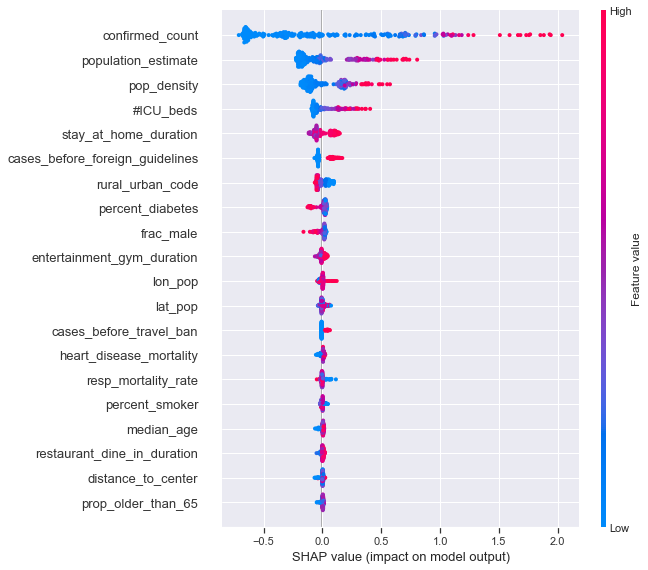

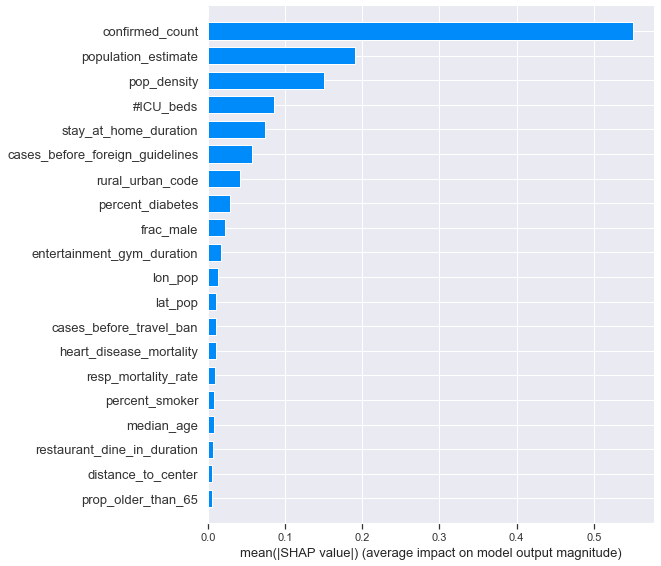

In [ ]:
shap.initjs()

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(best_grid)
shap_values = explainer.shap_values(X_test)

# visualize the first 100 prediction's explanation
shap.force_plot(explainer.expected_value, shap_values, X_test)

# plot
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')


# END OF REGRESSION

## SIR Model Fitting

## EDA

In [ ]:
# create a new df containing confirmed data count for each state over time
confirmed_states = (confirmed_data_og.drop(['UID','iso2','iso3','code3',
                                        'FIPS', 'Admin2', 
                                        'Lat', 'Long_'], axis=1)
                 .groupby('Province_State').sum().T
                   )

# only contiguous USA
confirmed_states = confirmed_states.drop(['Alaska', 'Diamond Princess', 
                                          'American Samoa', 'Grand Princess', 
                                          'Guam', 'Hawaii','Northern Mariana Islands',
                                         'Puerto Rico', 'Virgin Islands'], axis=1)

# convert index to datetime
confirmed_states.index = pd.to_datetime(confirmed_states.index, infer_datetime_format=True) 
confirmed_states = confirmed_states.rename_axis(None, axis=1)

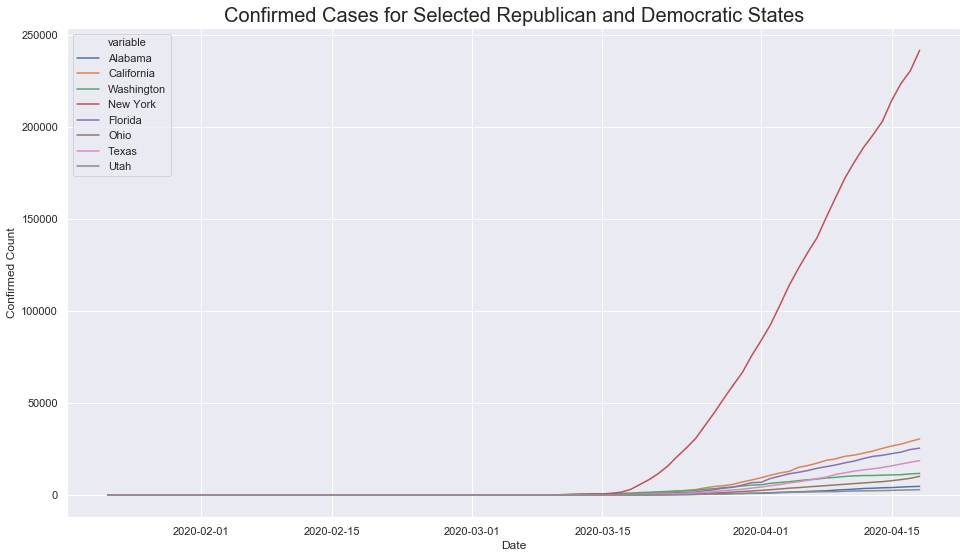

In [ ]:
# plot the count of confirmed cases for selected republican and democrat states

states = ['Alabama', 
          'California', 
          'Washington',
          'New York', 
          'Florida', 
          'Ohio', 
          'Texas', 
          'Utah']

confirmed_states_melt = pd.melt(confirmed_states.reset_index(), id_vars =['index'], value_vars=states)

# visualize increase in confirmed case count over time for USA
plt.figure(figsize=(16, 9))
ax = sns.lineplot(x="index", y="value", hue='variable', data=confirmed_states_melt)
ax.set_xlabel('Date')
ax.set_ylabel('Confirmed Count')
plt.legend(loc='upper left')
ax.set_title('Confirmed Cases for Selected Republican and Democratic States', fontsize=20);

In [ ]:
# create dataframe of number of cases per day for all of US
confirmed_usa = (confirmed_data_og.drop(['UID','iso2','iso3','code3',
                                        'FIPS', 'Admin2', 'Province_State',
                                        'Lat', 'Long_'], axis=1)
                 .groupby('Country_Region').sum().T
                 .rename(columns = {'US': 'total'}))

In [ ]:
# convert index to datetime
confirmed_usa.index = pd.to_datetime(confirmed_usa.index, infer_datetime_format=True)
confirmed_usa = confirmed_usa.rename_axis(None, axis=1)

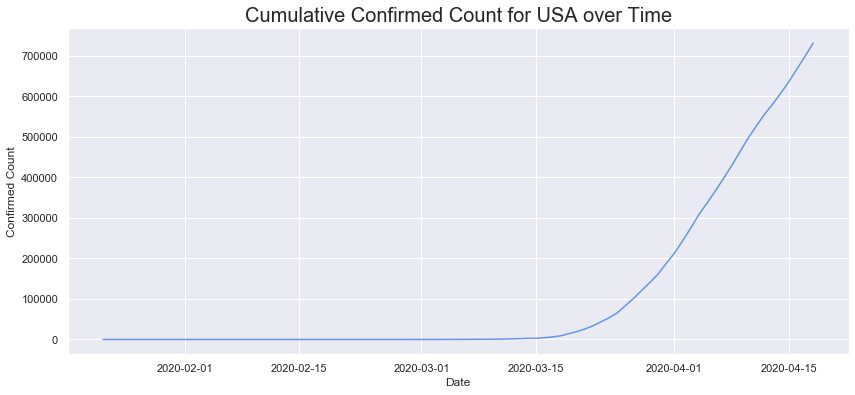

In [ ]:
# visualize increase in confirmed case count over time for USA
plt.figure(figsize=(14, 6))
ax = sns.lineplot(x=confirmed_usa.index, y=confirmed_usa.total, color='cornflowerblue')
ax.set_xlabel('Date')
ax.set_ylabel('Confirmed Count')
ax.set_title('Cumulative Confirmed Count for USA over Time', fontsize=20);

In [ ]:
# need to find the number of new cases from one day to the next
# first, make a column new to represent the count of new cases. for now, fill it with the data from total column
confirmed_usa['new'] = confirmed_usa['total'].shift(1).fillna(0)

In [ ]:
# to find the number of new cases each day, subtract the shifted total column from the original total column
confirmed_usa['new'] = confirmed_usa['total'] - confirmed_usa['new']

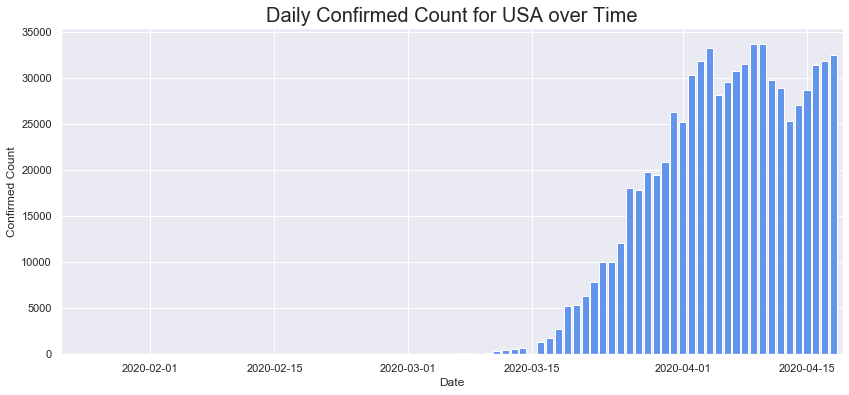

In [ ]:
# plot daily counts
plt.figure(figsize=(14, 6))

plt.bar(x=confirmed_usa.index, height=confirmed_usa.new, color='cornflowerblue')
plt.xlabel('Date')
plt.ylabel('Confirmed Count')
plt.title('Daily Confirmed Count for USA over Time', fontsize=20)
plt.xlim(confirmed_usa.index.min(),pd.to_datetime('2020-04-19'));

In [ ]:
# SIR model curve will be used to model the count of infected individuals each day
# first, we start by creating a dataset with only the daily cases
data = confirmed_usa.new

# get the estimate of the total population
N = county_data.population_estimate.sum()

In [ ]:
# create the SIR model
def SIR(S0, I0, R0, T, beta, gamma, N):
    S_list = [S0]
    I_list = [I0]
    R_list = [R0]
    for t in range(1, T):
        S, I, R = S_list[-1], I_list[-1], R_list[-1]
        S_list.append(S - beta*I*S/N)
        I_list.append(I + beta*I*S/N - gamma*I)
        R_list.append(R + gamma*I)
    return S_list, I_list, R_list

In [ ]:
# create the function to predictI given certain gamma and beta parameters
def I_pred(beta, gamma):
    _, I_pred, _ = SIR(N-1, 1, 0, 88, beta, gamma, N)
    return np.array(I_pred)

In [ ]:
# define the loss function
def loss(params):
    beta, gamma = params
    pred = I_pred(beta, gamma)
    I = np.array(data)
    return np.mean(np.square(I - pred))

In [ ]:
# minimize the loss function using scipy's optimizer
res = minimize(loss, (2, 0.1), method = 'Nelder-Mead')

In [ ]:
# beta and gamma parameters obtained
res.x

array([11.28465218, 11.1226133 ])

In [ ]:
# predict I, the number of infected people at a given day
pred = I_pred(res.x[0], res.x[1])

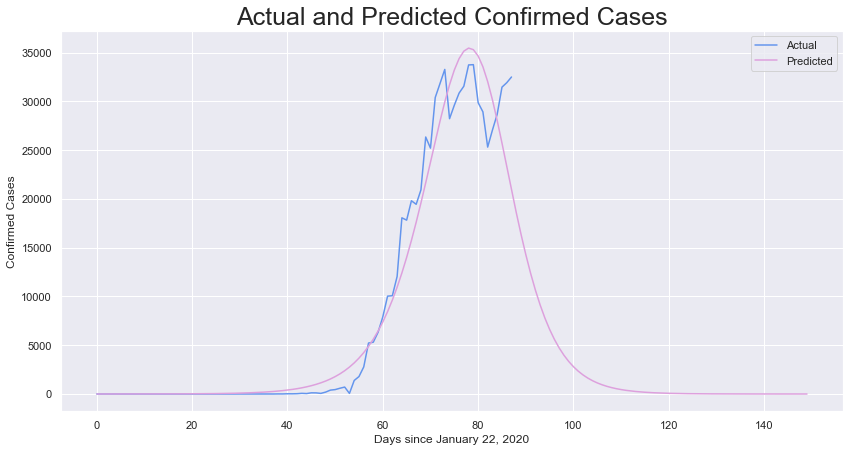

In [ ]:
# plot actual I and predicted I
I = np.array(data)
predS, predI, predR = SIR(N-1, 1, 0, 150, res.x[0], res.x[1], N) 

plt.figure(figsize=(14, 7))
plt.plot(I, color='cornflowerblue')
plt.plot(predI, color='plum')
plt.ylabel('Confirmed Cases')
plt.xlabel('Days since January 22, 2020')
plt.title('Actual and Predicted Confirmed Cases', fontsize=25)
plt.legend(labels=['Actual', 'Predicted']);